In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.read_csv('action1.csv').tail()

lh  rh     ls     rs    w  ll   rl       0x       0y       1x  ...  \
3372  341   0   5909   9181  278   0  361  995.334  227.190  995.225  ...   
3373  335   0   6434   7678  278   0  365  998.094  227.202  995.334  ...   
3374  327   0  11304  10704  276   0  366  998.363  221.252  998.229  ...   
3375  321   0  11021  10376  275   0  368  998.135  230.063  995.333  ...   
3376  308   0  12518  10677  271   0  365  998.122  230.075  995.326  ...   

          20x      20y      21x      21y      22x      22y      23x      23y  \
3372  1112.97  1018.80  1048.35  980.668  818.735  998.230  815.820  980.655   
3373  1110.14  1018.79  1048.41  980.631  818.763  998.207  815.827  980.617   
3374  1110.14  1015.94  1051.20  980.672  821.695  998.316  815.880  983.552   
3375  1112.97  1018.77  1048.42  980.668  821.650  998.217  818.670  980.615   
3376  1110.12  1015.92  1048.33  980.554  821.685  998.216  818.685  980.615   

          24x      24y  
3372  895.260  968.814  
3373  895.242  968.873  
3374  895.242  965.875  
3375  895.286  965.889  
3376  895.222  965.881  

[5 rows x 57 columns]

In [3]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('action1.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,7:57].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [4]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros((len(data)-lookback, 50))
print(inputs.shape)
print(labels.shape)
for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i][7:57]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1, 50)
print(inputs.shape)
print(labels.shape)

(3367, 10, 57)
(3367, 50)
(3367, 10, 57)
(3367, 50)


In [5]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]
print(test_y)
labs = torch.from_numpy(np.array(test_y))
label_sc.inverse_transform(labs)

[[0.99059549 0.53348462 0.80883156 ... 0.24408777 0.66784452 0.25181373]
 [0.88406124 0.39861568 0.79641005 ... 0.25296679 0.00911889 0.74464316]
 [0.88534026 0.39770793 0.7996178  ... 0.25151541 0.34184429 0.74987346]
 ...
 [0.88725877 0.39850221 0.80132405 ... 0.50038419 0.33796877 0.49805973]
 [0.87868186 0.59845683 0.60367185 ... 0.24963716 0.34298416 0.49924076]
 [0.87819283 0.59872915 0.6031941  ... 0.24963716 0.33568905 0.49856588]]


array([[1001.11 ,  227.2  ,  998.339, ...,  980.55 ,  898.136,  962.956],
       [ 998.278,  221.257,  998.157, ...,  980.654,  892.357,  968.798],
       [ 998.312,  221.217,  998.204, ...,  980.637,  895.276,  968.86 ],
       ...,
       [ 998.363,  221.252,  998.229, ...,  983.552,  895.242,  965.875],
       [ 998.135,  230.063,  995.333, ...,  980.615,  895.286,  965.889],
       [ 998.122,  230.075,  995.326, ...,  980.615,  895.222,  965.881]])

In [6]:
print(test_y)

[[0.99059549 0.53348462 0.80883156 ... 0.24408777 0.66784452 0.25181373]
 [0.88406124 0.39861568 0.79641005 ... 0.25296679 0.00911889 0.74464316]
 [0.88534026 0.39770793 0.7996178  ... 0.25151541 0.34184429 0.74987346]
 ...
 [0.88725877 0.39850221 0.80132405 ... 0.50038419 0.33796877 0.49805973]
 [0.87868186 0.59845683 0.60367185 ... 0.24963716 0.34298416 0.49924076]
 [0.87819283 0.59872915 0.6031941  ... 0.24963716 0.33568905 0.49856588]]


In [7]:
batch_size = 20

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
input_dim = next(iter(train_loader))[0].shape
print(input_dim)

torch.Size([20, 10, 57])


In [8]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
print(device)

cpu


In [10]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [11]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 50
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [12]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [13]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/151....... Average Loss for Epoch: 0.35311105847358704
Epoch 1......Step: 2/151....... Average Loss for Epoch: 0.3298538327217102
Epoch 1......Step: 3/151....... Average Loss for Epoch: 0.3034321069717407
Epoch 1......Step: 4/151....... Average Loss for Epoch: 0.27183783054351807
Epoch 1......Step: 5/151....... Average Loss for Epoch: 0.24057267159223555
Epoch 1......Step: 6/151....... Average Loss for Epoch: 0.21384467681248984
Epoch 1......Step: 7/151....... Average Loss for Epoch: 0.19451300480536052
Epoch 1......Step: 8/151....... Average Loss for Epoch: 0.18026837520301342
Epoch 1......Step: 9/151....... Average Loss for Epoch: 0.16704640082187122
Epoch 1......Step: 10/151....... Average Loss for Epoch: 0.15453157760202885
Epoch 1......Step: 11/151....... Average Loss for Epoch: 0.14490568874911827
Epoch 1......Step: 12/151....... Average Loss for Epoch: 0.13677233116080365
Epoch 1......Step: 13/151....... Average Loss for Epoch:

Epoch 1......Step: 113/151....... Average Loss for Epoch: 0.03922677081309061
Epoch 1......Step: 114/151....... Average Loss for Epoch: 0.039058231013385875
Epoch 1......Step: 115/151....... Average Loss for Epoch: 0.038950343915949696
Epoch 1......Step: 116/151....... Average Loss for Epoch: 0.03883830851329298
Epoch 1......Step: 117/151....... Average Loss for Epoch: 0.038688913831471376
Epoch 1......Step: 118/151....... Average Loss for Epoch: 0.03854917654357219
Epoch 1......Step: 119/151....... Average Loss for Epoch: 0.03839864736782903
Epoch 1......Step: 120/151....... Average Loss for Epoch: 0.03830382699767749
Epoch 1......Step: 121/151....... Average Loss for Epoch: 0.03819553589463726
Epoch 1......Step: 122/151....... Average Loss for Epoch: 0.0380806974364353
Epoch 1......Step: 123/151....... Average Loss for Epoch: 0.03794184433129745
Epoch 1......Step: 124/151....... Average Loss for Epoch: 0.03782459471615091
Epoch 1......Step: 125/151....... Average Loss for Epoch: 0.03

Epoch 2......Step: 69/151....... Average Loss for Epoch: 0.021889312894663948
Epoch 2......Step: 70/151....... Average Loss for Epoch: 0.021901690800275122
Epoch 2......Step: 71/151....... Average Loss for Epoch: 0.0218527270874507
Epoch 2......Step: 72/151....... Average Loss for Epoch: 0.021881735004070733
Epoch 2......Step: 73/151....... Average Loss for Epoch: 0.02183280186089751
Epoch 2......Step: 74/151....... Average Loss for Epoch: 0.021777490556642815
Epoch 2......Step: 75/151....... Average Loss for Epoch: 0.021729515343904496
Epoch 2......Step: 76/151....... Average Loss for Epoch: 0.021694762681267764
Epoch 2......Step: 77/151....... Average Loss for Epoch: 0.021631842793582323
Epoch 2......Step: 78/151....... Average Loss for Epoch: 0.021608252555896074
Epoch 2......Step: 79/151....... Average Loss for Epoch: 0.02163363889425616
Epoch 2......Step: 80/151....... Average Loss for Epoch: 0.021605508169159293
Epoch 2......Step: 81/151....... Average Loss for Epoch: 0.021567992

Epoch 3......Step: 24/151....... Average Loss for Epoch: 0.019730425206944346
Epoch 3......Step: 25/151....... Average Loss for Epoch: 0.019702470526099206
Epoch 3......Step: 26/151....... Average Loss for Epoch: 0.019641138183382843
Epoch 3......Step: 27/151....... Average Loss for Epoch: 0.019411122598857793
Epoch 3......Step: 28/151....... Average Loss for Epoch: 0.01928167194793267
Epoch 3......Step: 29/151....... Average Loss for Epoch: 0.019315147868775088
Epoch 3......Step: 30/151....... Average Loss for Epoch: 0.01928866794332862
Epoch 3......Step: 31/151....... Average Loss for Epoch: 0.019225769255670808
Epoch 3......Step: 32/151....... Average Loss for Epoch: 0.019133373658405617
Epoch 3......Step: 33/151....... Average Loss for Epoch: 0.019006774111679108
Epoch 3......Step: 34/151....... Average Loss for Epoch: 0.018907821792013505
Epoch 3......Step: 35/151....... Average Loss for Epoch: 0.018778325138347488
Epoch 3......Step: 36/151....... Average Loss for Epoch: 0.0187831

Epoch 3......Step: 129/151....... Average Loss for Epoch: 0.019105310984995474
Epoch 3......Step: 130/151....... Average Loss for Epoch: 0.019179423002956004
Epoch 3......Step: 131/151....... Average Loss for Epoch: 0.01917188272647958
Epoch 3......Step: 132/151....... Average Loss for Epoch: 0.01921697722211706
Epoch 3......Step: 133/151....... Average Loss for Epoch: 0.01918340897313634
Epoch 3......Step: 134/151....... Average Loss for Epoch: 0.01919513351436871
Epoch 3......Step: 135/151....... Average Loss for Epoch: 0.019178140535950662
Epoch 3......Step: 136/151....... Average Loss for Epoch: 0.019145990043933338
Epoch 3......Step: 137/151....... Average Loss for Epoch: 0.019134715845278146
Epoch 3......Step: 138/151....... Average Loss for Epoch: 0.019188077101294977
Epoch 3......Step: 139/151....... Average Loss for Epoch: 0.019259461496534538
Epoch 3......Step: 140/151....... Average Loss for Epoch: 0.019229852947007332
Epoch 3......Step: 141/151....... Average Loss for Epoch

Epoch 4......Step: 82/151....... Average Loss for Epoch: 0.01870081656635171
Epoch 4......Step: 83/151....... Average Loss for Epoch: 0.018678615397089218
Epoch 4......Step: 84/151....... Average Loss for Epoch: 0.018640720374172644
Epoch 4......Step: 85/151....... Average Loss for Epoch: 0.018607581516399102
Epoch 4......Step: 86/151....... Average Loss for Epoch: 0.01863150133989578
Epoch 4......Step: 87/151....... Average Loss for Epoch: 0.018685934315810258
Epoch 4......Step: 88/151....... Average Loss for Epoch: 0.018666940487243912
Epoch 4......Step: 89/151....... Average Loss for Epoch: 0.018696098326799575
Epoch 4......Step: 90/151....... Average Loss for Epoch: 0.01867509368393156
Epoch 4......Step: 91/151....... Average Loss for Epoch: 0.01864851000053542
Epoch 4......Step: 92/151....... Average Loss for Epoch: 0.018624189815929403
Epoch 4......Step: 93/151....... Average Loss for Epoch: 0.018600745567230768
Epoch 4......Step: 94/151....... Average Loss for Epoch: 0.018615888

Epoch 5......Step: 38/151....... Average Loss for Epoch: 0.01782967405099618
Epoch 5......Step: 39/151....... Average Loss for Epoch: 0.017730014995695688
Epoch 5......Step: 40/151....... Average Loss for Epoch: 0.01768985001835972
Epoch 5......Step: 41/151....... Average Loss for Epoch: 0.017883635444066872
Epoch 5......Step: 42/151....... Average Loss for Epoch: 0.017942956183105707
Epoch 5......Step: 43/151....... Average Loss for Epoch: 0.018103185326380784
Epoch 5......Step: 44/151....... Average Loss for Epoch: 0.018144640923393043
Epoch 5......Step: 45/151....... Average Loss for Epoch: 0.018162880941397615
Epoch 5......Step: 46/151....... Average Loss for Epoch: 0.018077141888763592
Epoch 5......Step: 47/151....... Average Loss for Epoch: 0.01813626138770834
Epoch 5......Step: 48/151....... Average Loss for Epoch: 0.018179281381890178
Epoch 5......Step: 49/151....... Average Loss for Epoch: 0.018196908605037903
Epoch 5......Step: 50/151....... Average Loss for Epoch: 0.01817976

Epoch 5......Step: 142/151....... Average Loss for Epoch: 0.01766525961222573
Epoch 5......Step: 143/151....... Average Loss for Epoch: 0.01771019833566217
Epoch 5......Step: 144/151....... Average Loss for Epoch: 0.017715626001720212
Epoch 5......Step: 145/151....... Average Loss for Epoch: 0.017767172647190504
Epoch 5......Step: 146/151....... Average Loss for Epoch: 0.017769565174279557
Epoch 5......Step: 147/151....... Average Loss for Epoch: 0.017765180486552165
Epoch 5......Step: 148/151....... Average Loss for Epoch: 0.017763513864043193
Epoch 5......Step: 149/151....... Average Loss for Epoch: 0.017740484889621704
Epoch 5......Step: 150/151....... Average Loss for Epoch: 0.017738753221929072
Epoch 5......Step: 151/151....... Average Loss for Epoch: 0.017772588410124874
Epoch 5/5 Done, Total Loss: 0.017772588410124874
Time Elapsed for Epoch: 4.608891499999999 seconds
Total Training Time: 21.5046313 seconds


In [14]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.05645640000000185
sMAPE: 0.20513224237892433%


In [15]:
print(gru_outputs[0].reshape(-1, 50))

[[997.9746  222.1872  996.6409  ... 982.42053 894.8741  966.9569 ]
 [998.40704 223.92412 997.0594  ... 981.6779  895.2462  966.1562 ]
 [998.249   222.72765 996.47705 ... 981.8774  895.2372  966.1671 ]
 ...
 [995.4163  229.53801 995.5842  ... 981.30164 895.39984 967.0724 ]
 [995.0436  226.59804 995.9584  ... 981.1245  895.55225 965.8405 ]
 [995.2947  229.27783 995.5041  ... 980.923   895.6615  966.23785]]


In [16]:
print(targets[0].reshape(-1, 50))
print(targets[0].reshape(-1, 50)[-1].reshape(-1,2).tolist())

[[1001.11   227.2    998.339 ...  980.55   898.136  962.956]
 [ 998.278  221.257  998.157 ...  980.654  892.357  968.798]
 [ 998.312  221.217  998.204 ...  980.637  895.276  968.86 ]
 ...
 [ 998.363  221.252  998.229 ...  983.552  895.242  965.875]
 [ 998.135  230.063  995.333 ...  980.615  895.286  965.889]
 [ 998.122  230.075  995.326 ...  980.615  895.222  965.881]]
[[998.122, 230.07499999999996], [995.3260000000001, 341.85], [910.047, 341.8], [880.431, 412.657], [833.513, 480.244], [1071.86, 341.944], [1098.43, 412.716], [1124.82, 486.161], [977.7289999999999, 574.47], [930.581, 574.419], [909.998, 765.7139999999999], [883.4029999999999, 951.168], [1024.79, 574.51], [1048.38, 774.6120000000001], [1068.72, 971.7219999999999], [977.66, 218.315], [1015.8700000000001, 221.153], [954.02, 230.10899999999998], [1036.49, 241.75599999999997], [1095.31, 1024.82], [1110.12, 1015.92], [1048.33, 980.554], [821.685, 998.2160000000001], [818.685, 980.615], [895.2219999999999, 965.8810000000001]]


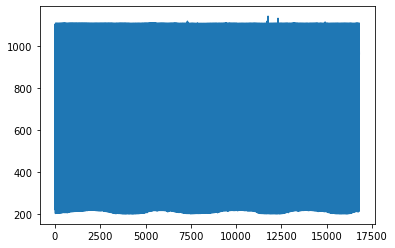

In [17]:
plt.plot(gru_outputs[0])
plt.show()

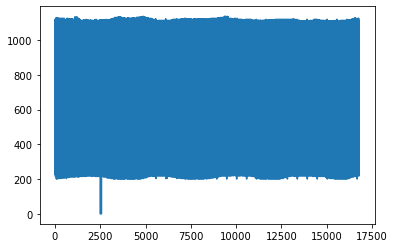

In [18]:
plt.plot(targets[0])
plt.show()

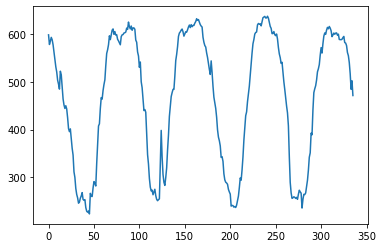

In [20]:
tp = []
for row in gru_outputs[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

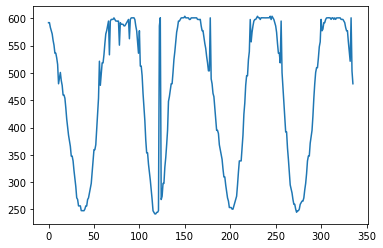

In [22]:
tp = []
for row in targets[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# h36m骨架连接顺序，每个骨架三个维度，分别为：起始关节，终止关节，左右关节标识(0 left 1 right)
connectivity_dict = [[0, 1, 0], [0, 15, 0], [0, 16, 1], [17, 15, 0], [18, 16, 1], [1, 2, 0], [2, 3, 0],
                              [3, 4, 0], [1, 5, 1], [5, 6, 1],
                              [6, 7, 1], [1, 8, 0], [8, 9, 0], [9, 10, 0], [10, 11, 0], [11, 24, 0],
                              [11, 22, 0], [22, 23, 0], [8, 12, 1], [12, 13, 1], [13, 14, 1], [14, 21, 1],
                              [14, 19, 1], [19, 20, 1]]


def draw2Dpose(pose_2d, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False):  # blue, orange
    for i in connectivity_dict:
        x, y = [np.array([pose_2d[i[0], j], pose_2d[i[1], j]]) for j in range(2)]
        ax.plot(x, y, lw=2, c=lcolor if i[2] else rcolor)
        

In [24]:
ps = []
for p in targets[0].reshape(-1, 50):
    ps.append(np.array(p.reshape(-1,2).tolist()))

print(ps)

[array([[1001.11 ,  227.2  ],
       [ 998.339,  347.772],
       [ 924.575,  342.082],
       [ 862.921,  412.656],
       [ 815.875,  592.105],
       [1074.79 ,  350.697],
       [1112.99 ,  424.306],
       [1119.08 ,  599.51 ],
       [ 986.544,  586.205],
       [ 939.441,  583.23 ],
       [ 910.025,  765.736],
       [ 883.468,  951.135],
       [1036.57 ,  586.219],
       [1048.37 ,  774.532],
       [1068.77 ,  968.771],
       [ 980.699,  215.4  ],
       [1021.74 ,  221.093],
       [ 957.069,  227.136],
       [1045.23 ,  238.946],
       [1095.35 , 1024.77 ],
       [1110.13 , 1015.92 ],
       [1051.19 ,  977.73 ],
       [ 827.501,  998.147],
       [ 821.691,  980.55 ],
       [ 898.136,  962.956]]), array([[ 998.278,  221.257],
       [ 998.157,  347.822],
       [ 909.909,  344.931],
       [ 880.637,  477.344],
       [ 839.373,  592.121],
       [1074.89 ,  350.805],
       [1110.09 ,  480.117],
       [1127.77 ,  598.107],
       [ 980.723,  594.957],
       [ 93

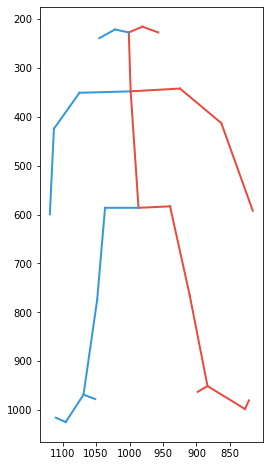

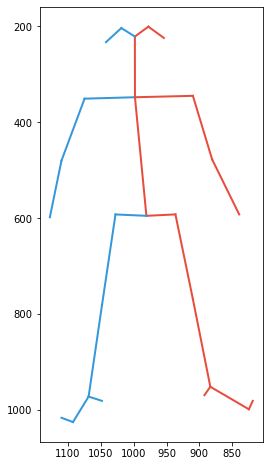

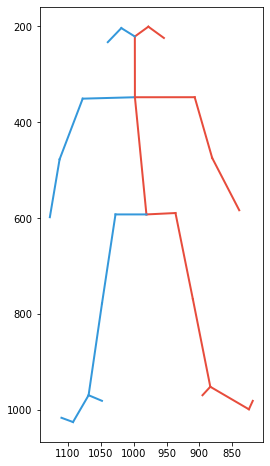

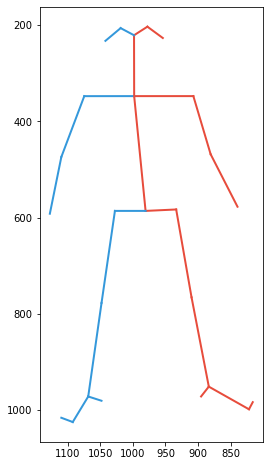

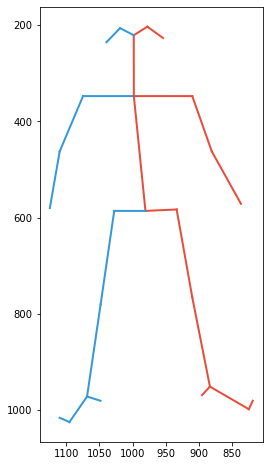

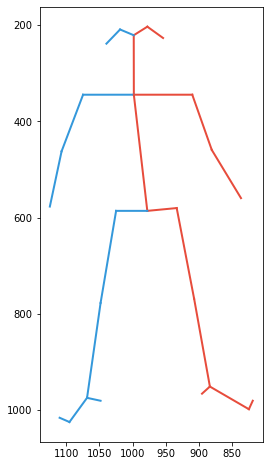

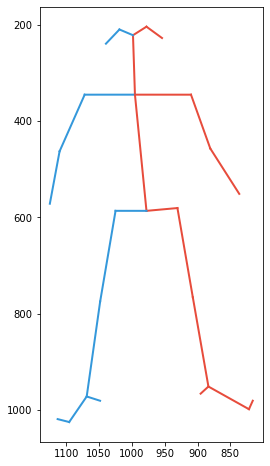

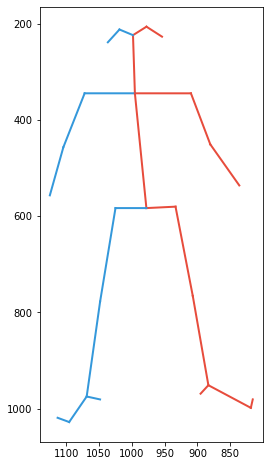

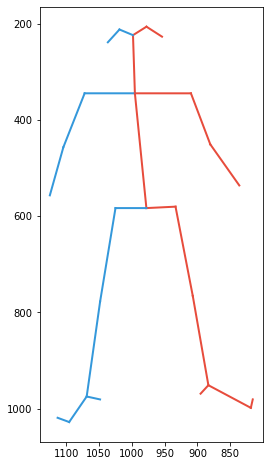

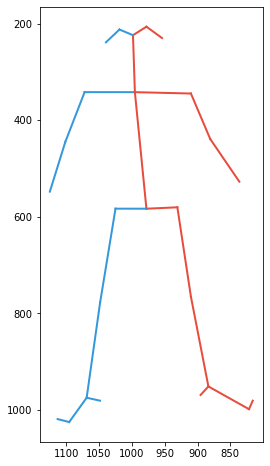

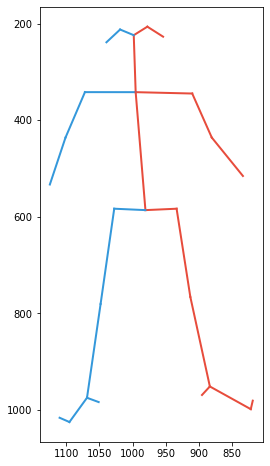

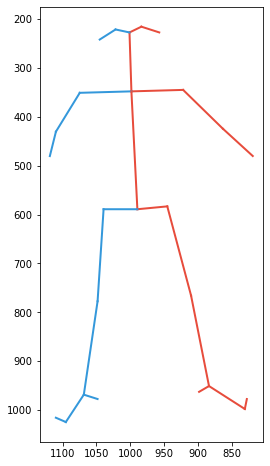

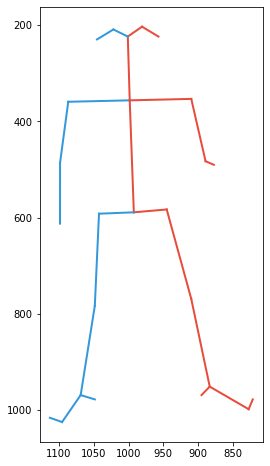

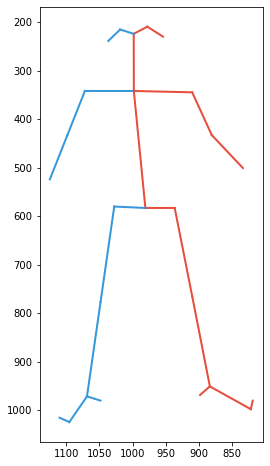

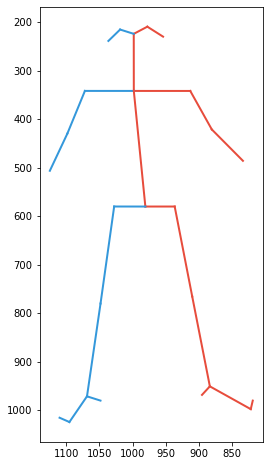

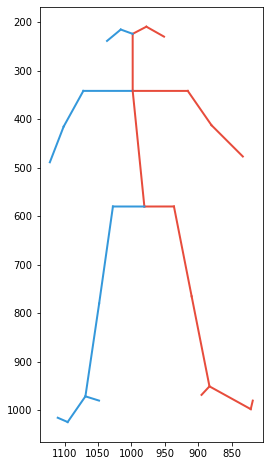

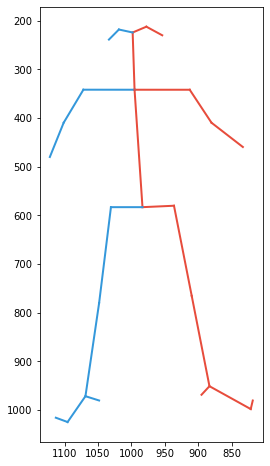

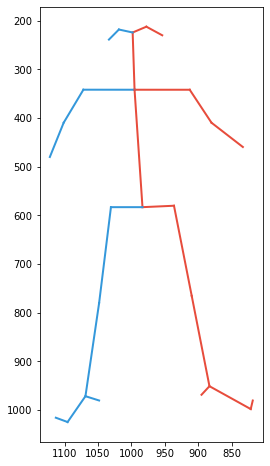

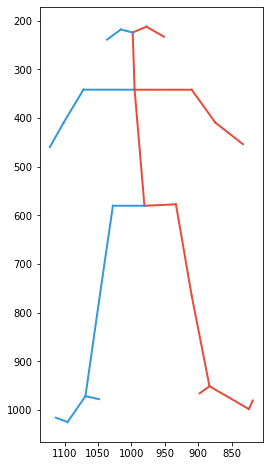

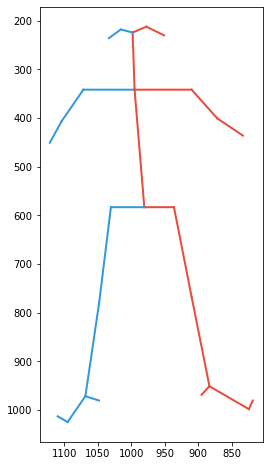

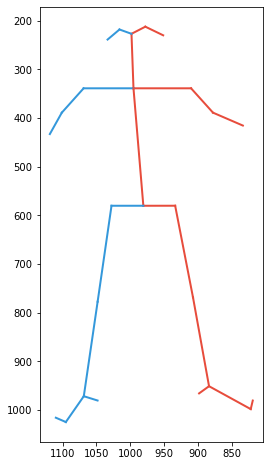

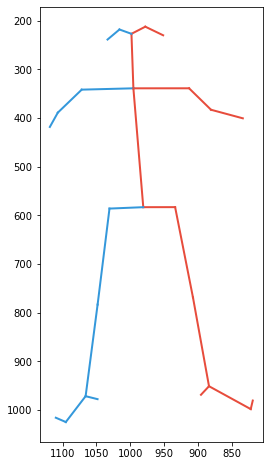

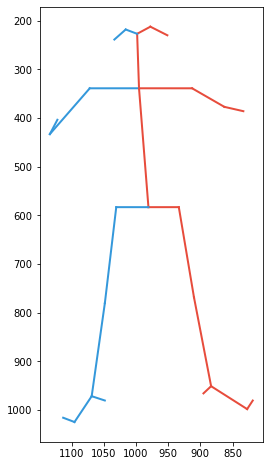

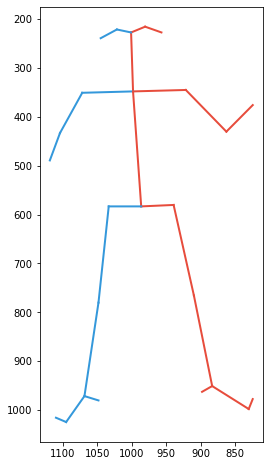

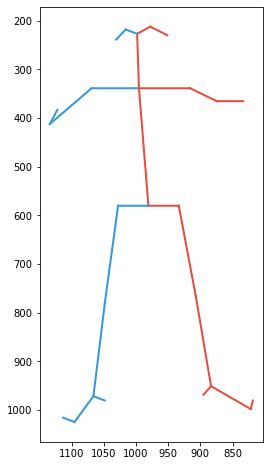

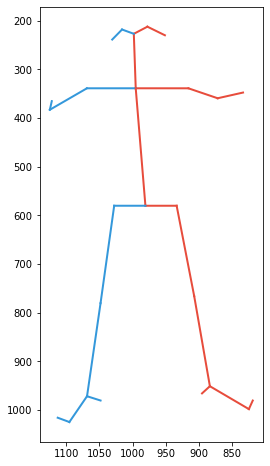

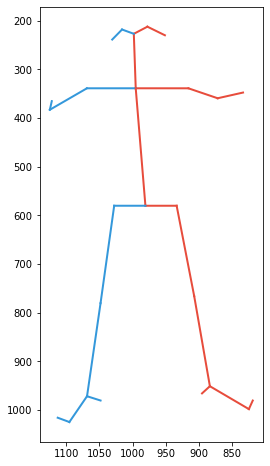

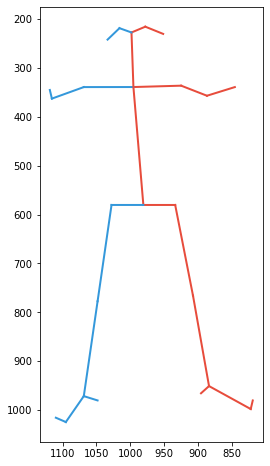

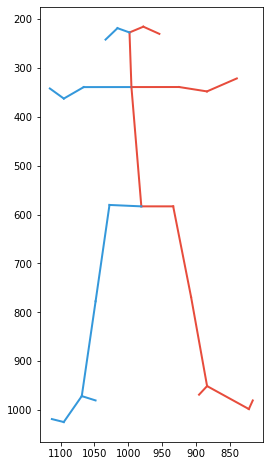

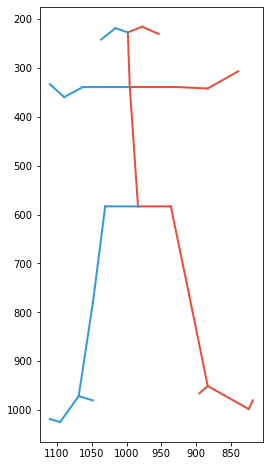

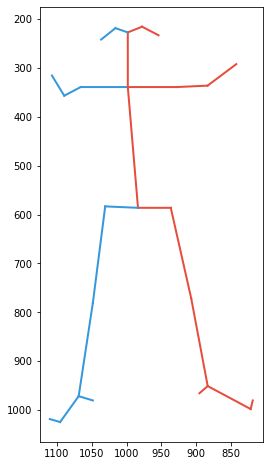

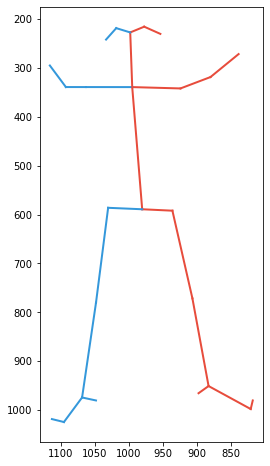

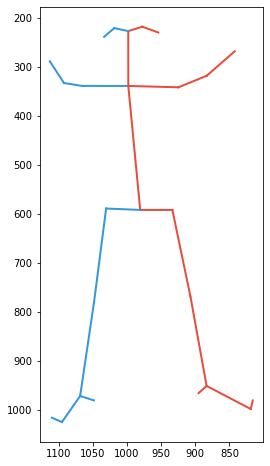

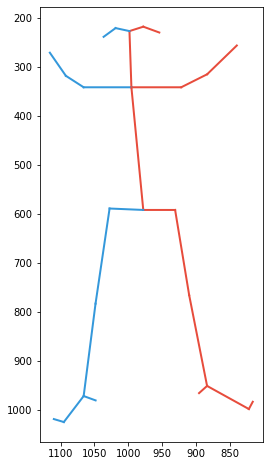

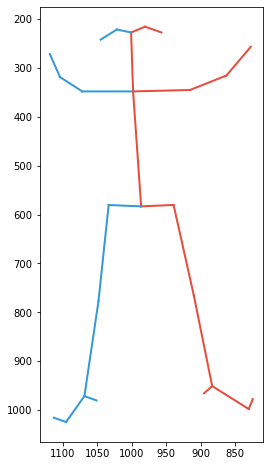

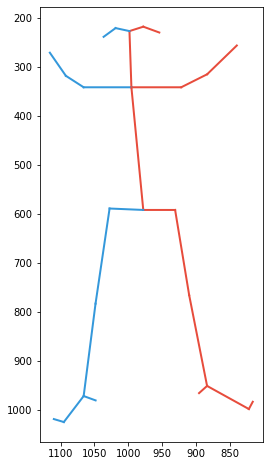

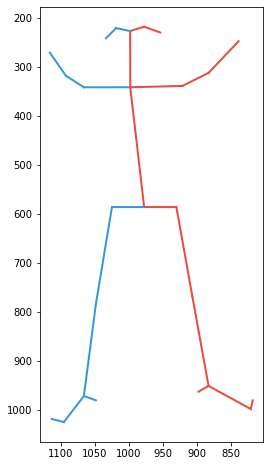

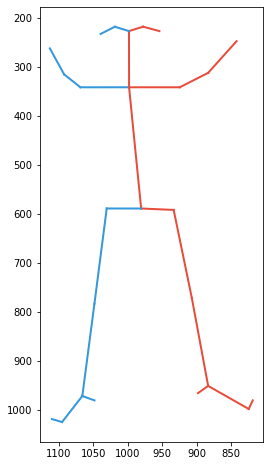

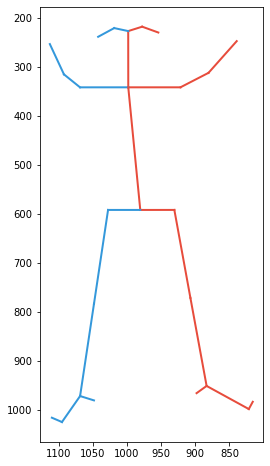

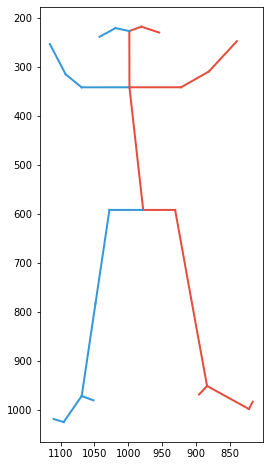

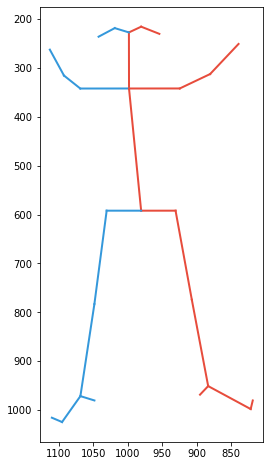

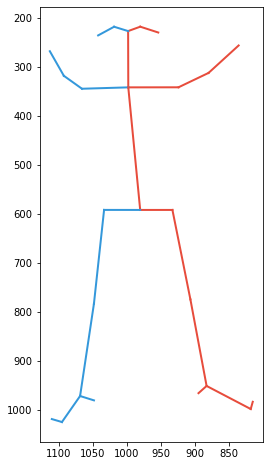

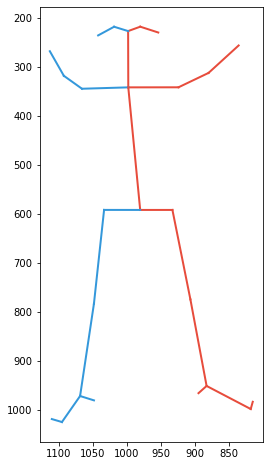

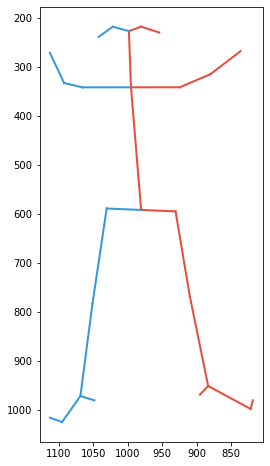

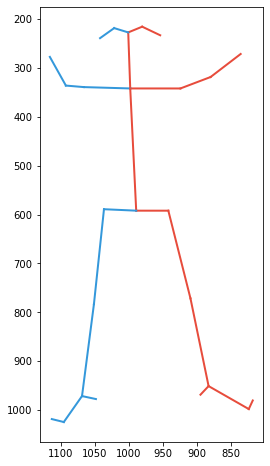

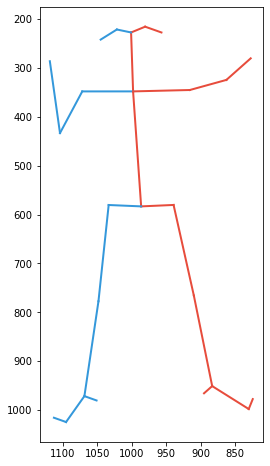

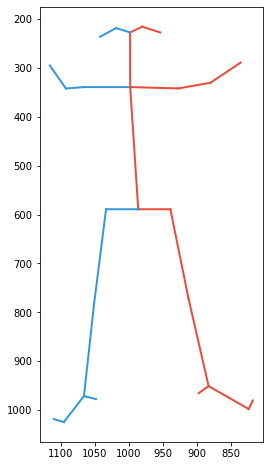

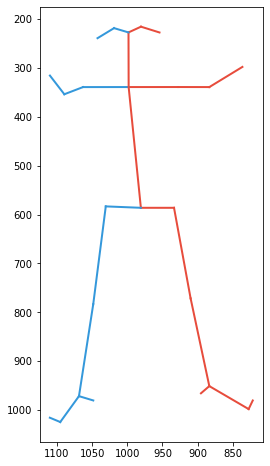

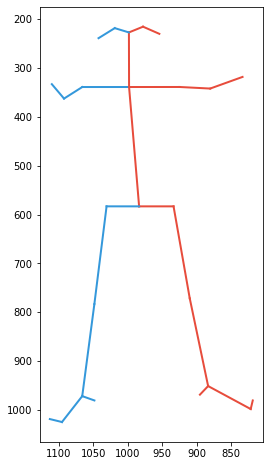

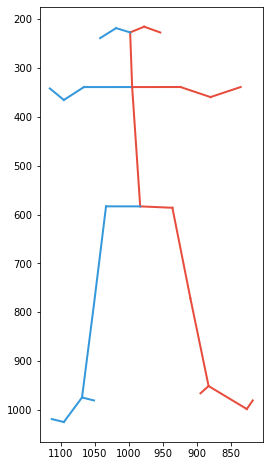

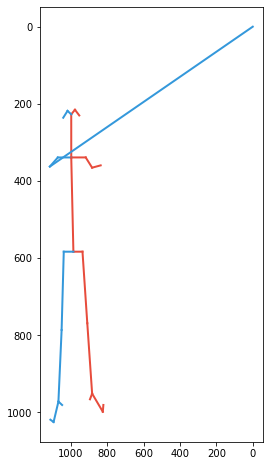

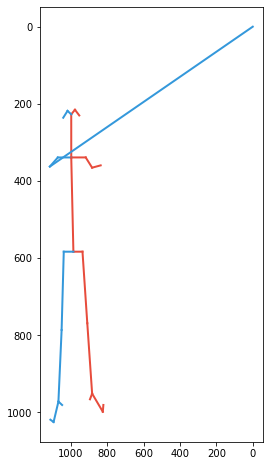

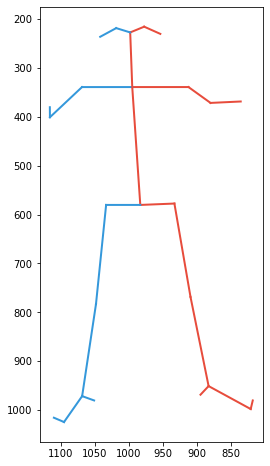

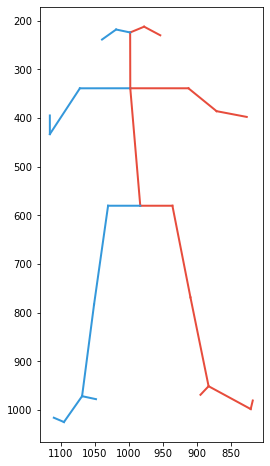

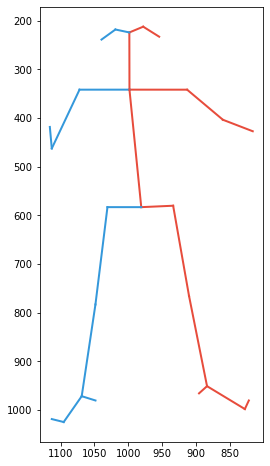

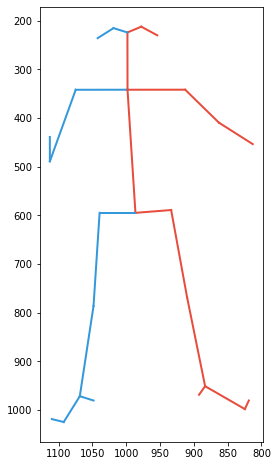

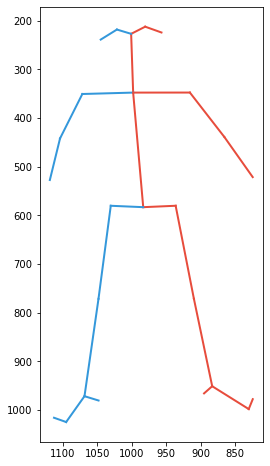

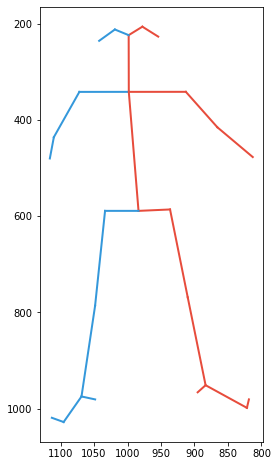

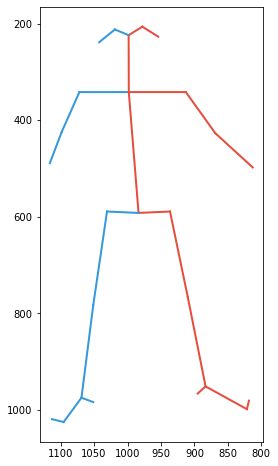

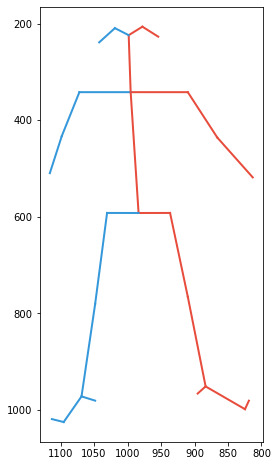

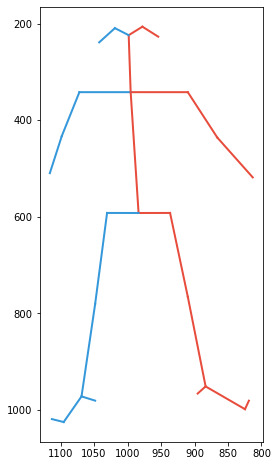

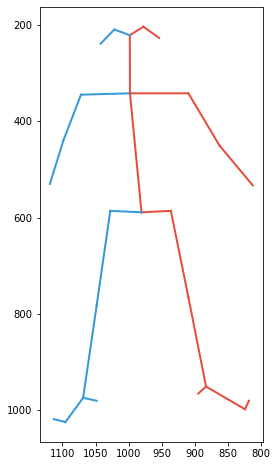

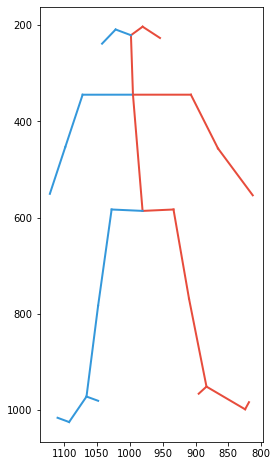

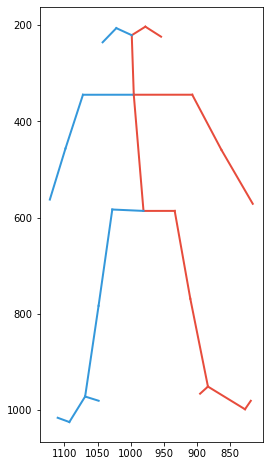

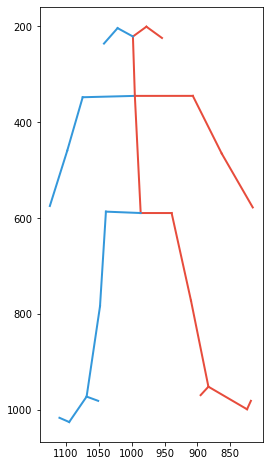

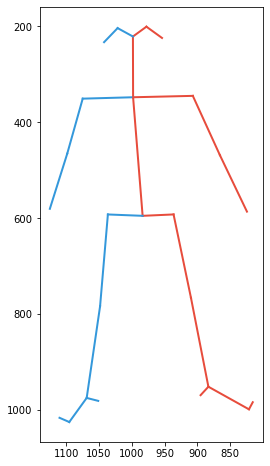

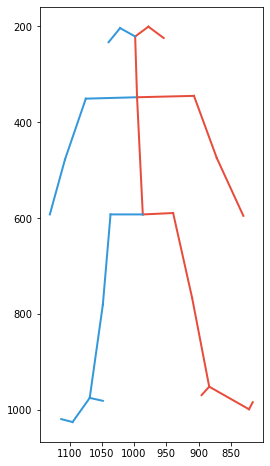

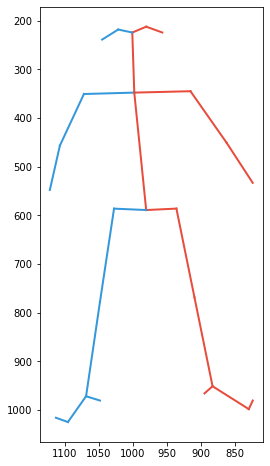

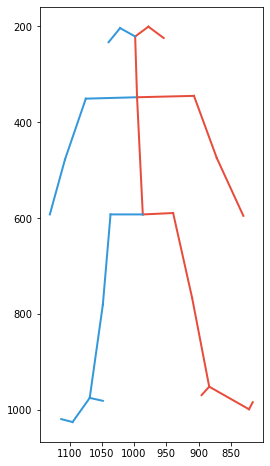

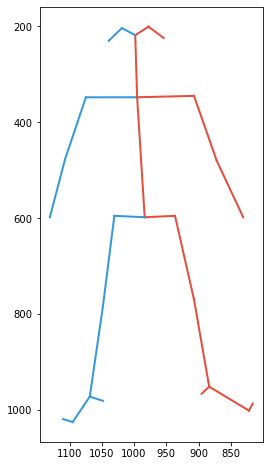

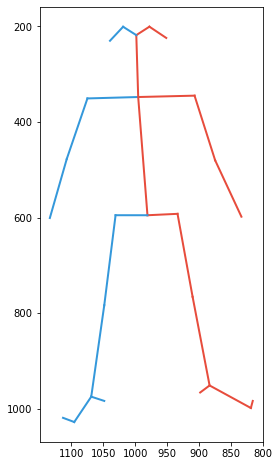

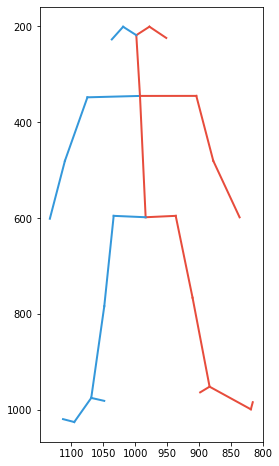

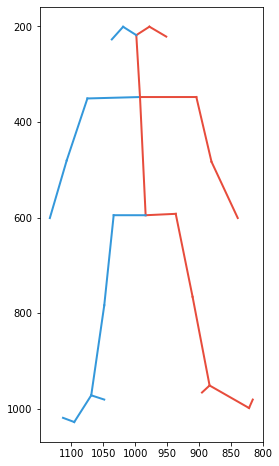

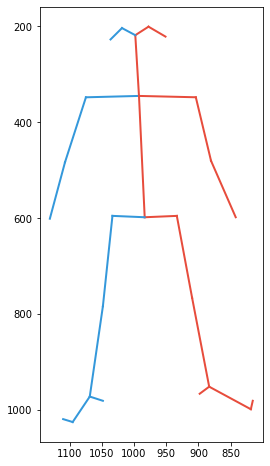

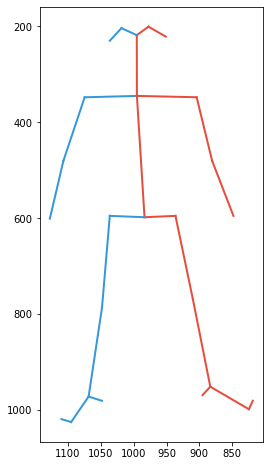

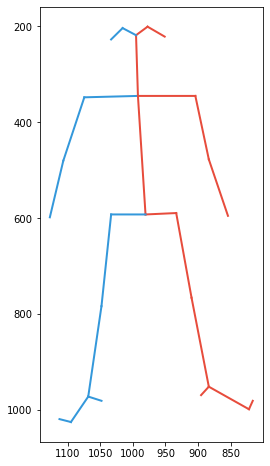

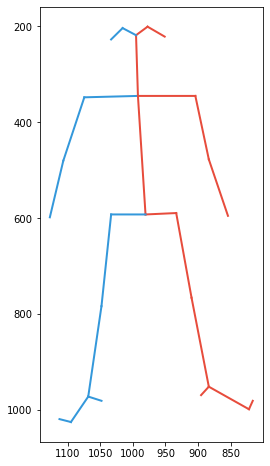

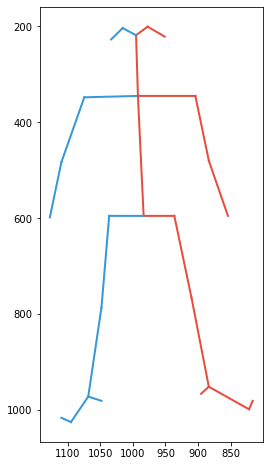

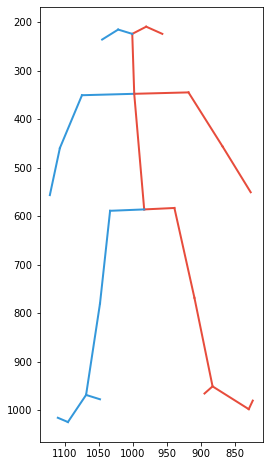

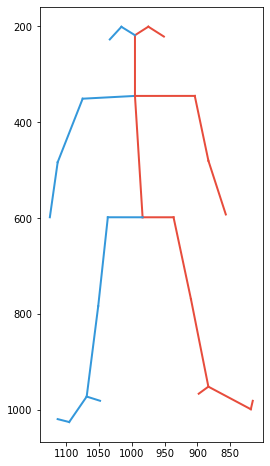

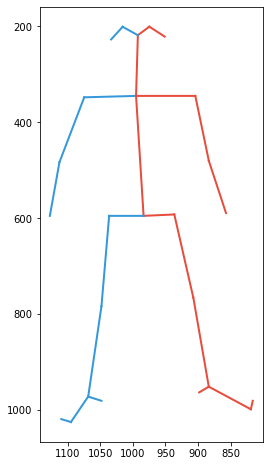

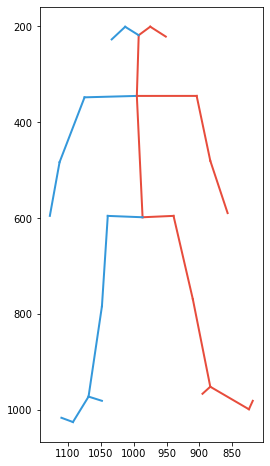

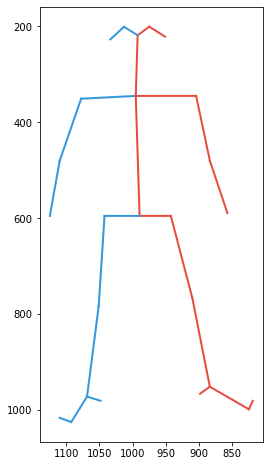

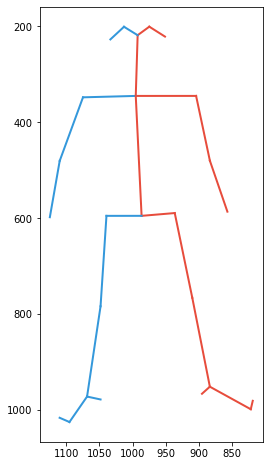

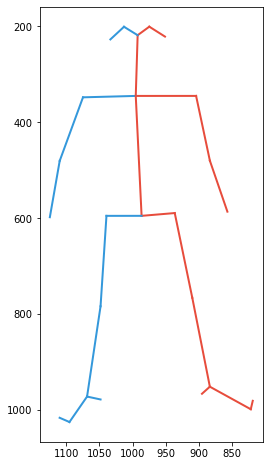

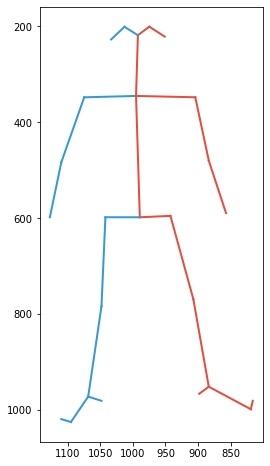

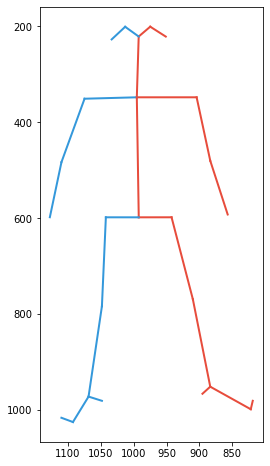

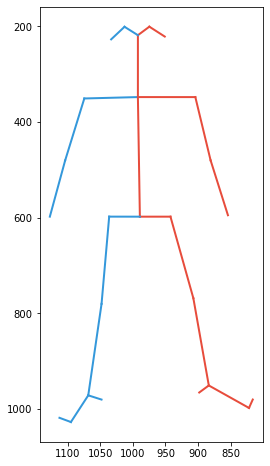

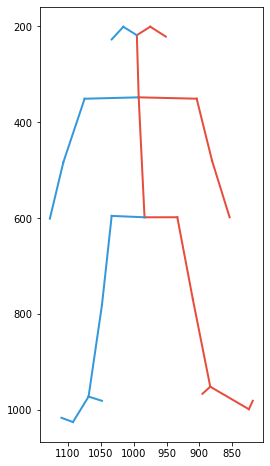

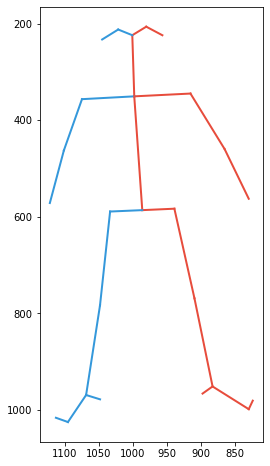

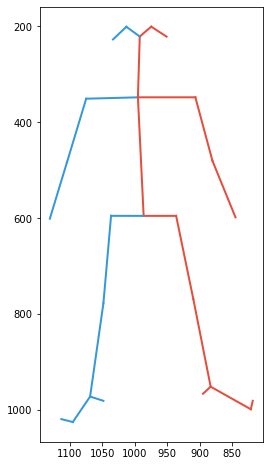

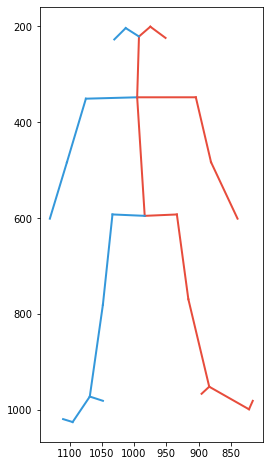

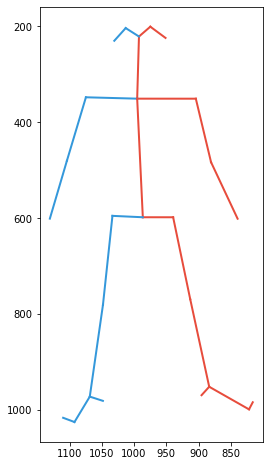

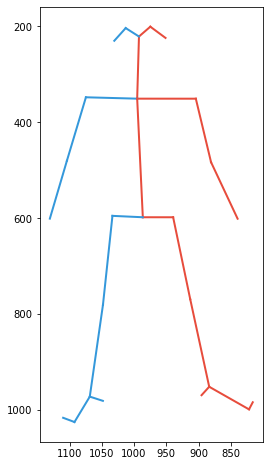

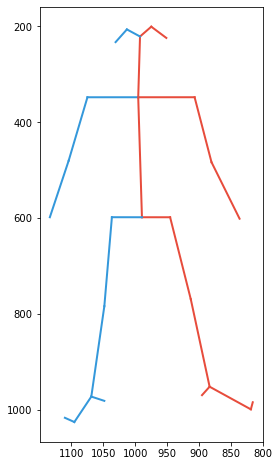

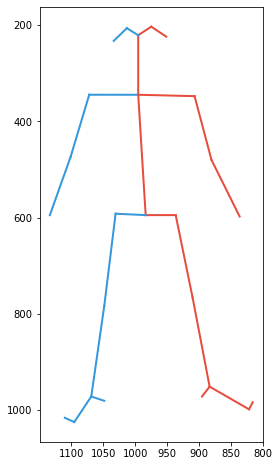

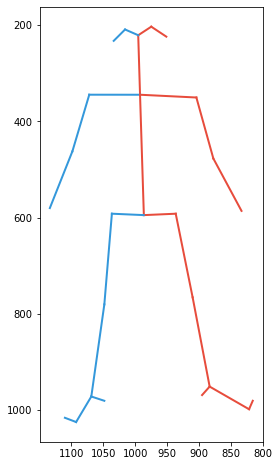

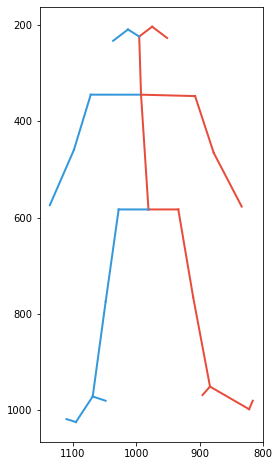

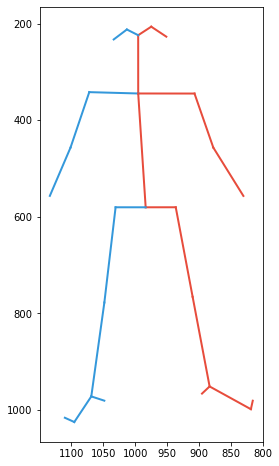

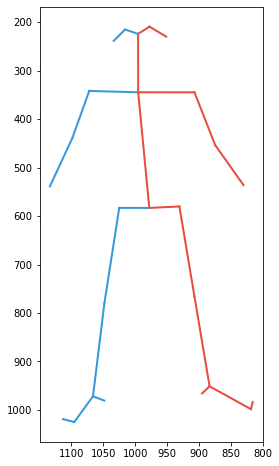

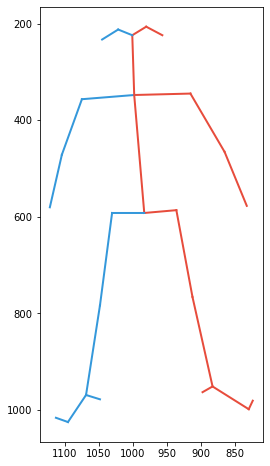

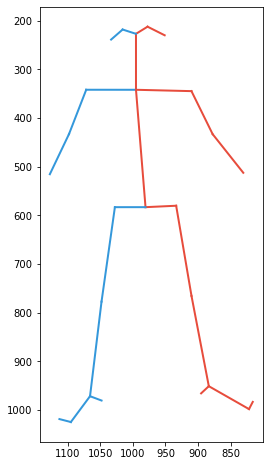

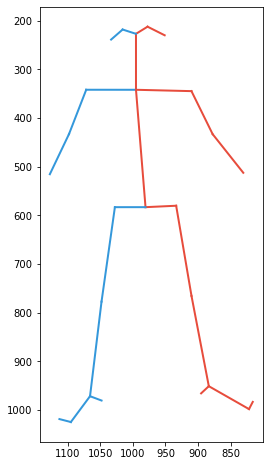

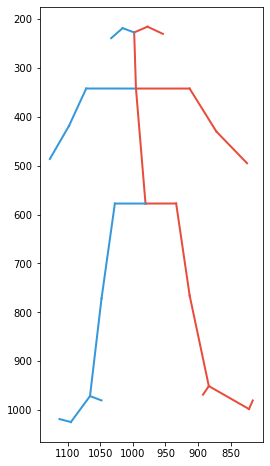

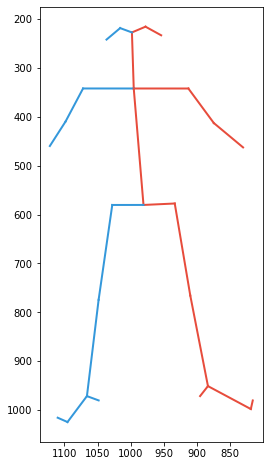

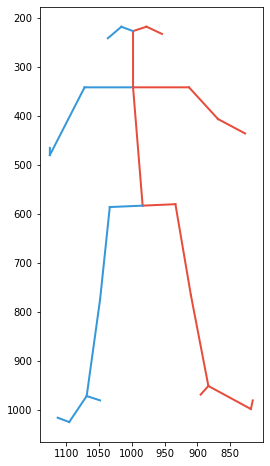

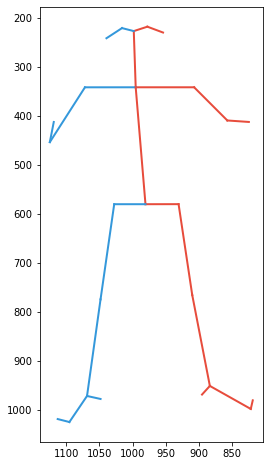

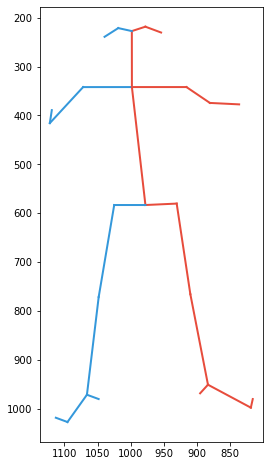

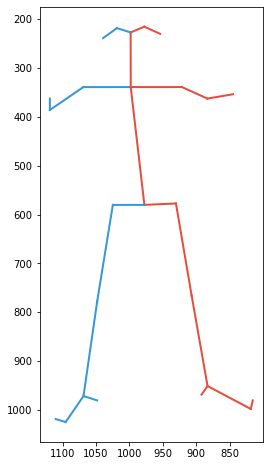

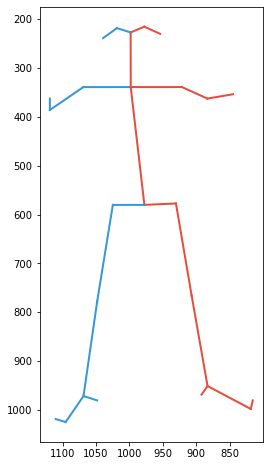

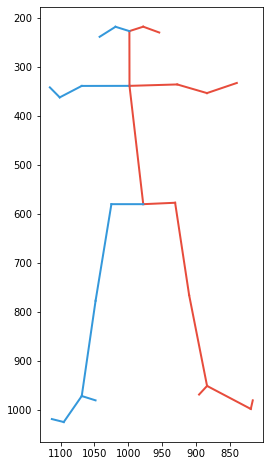

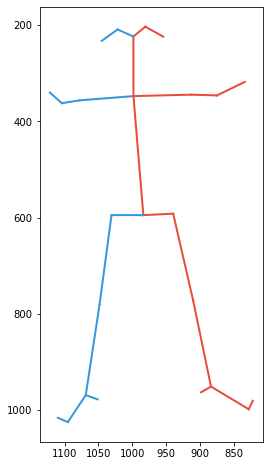

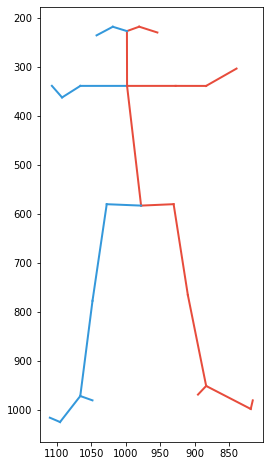

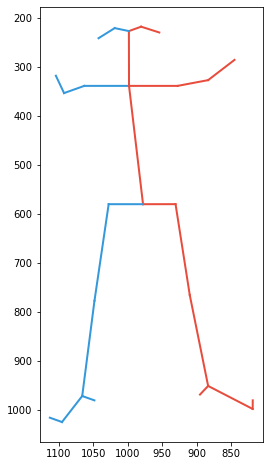

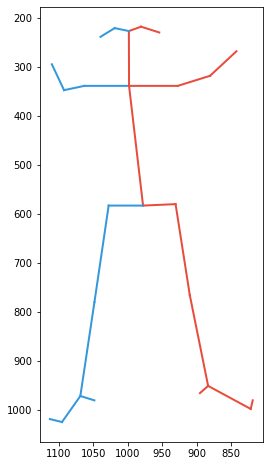

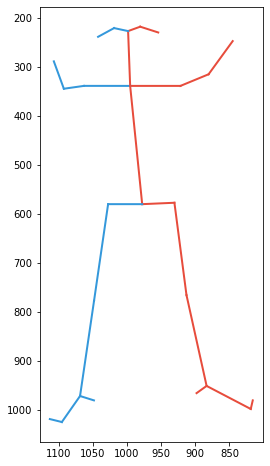

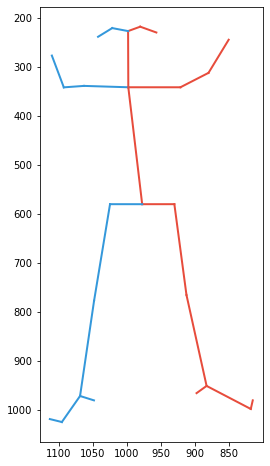

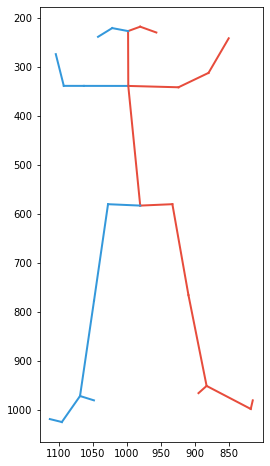

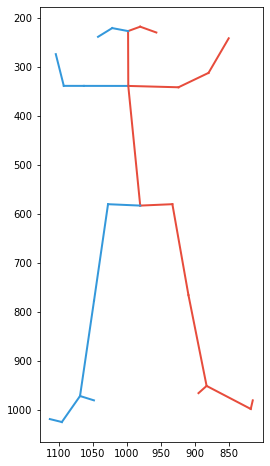

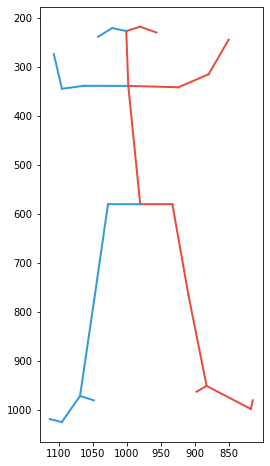

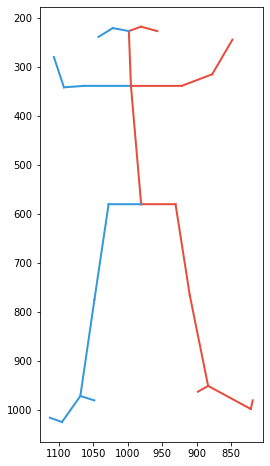

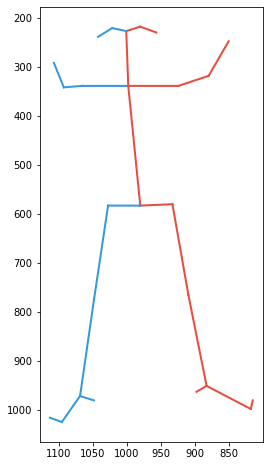

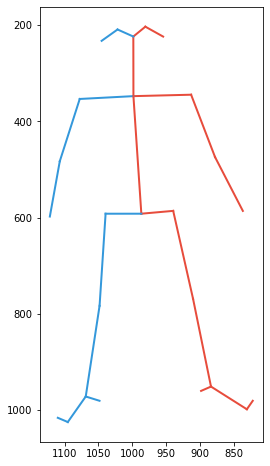

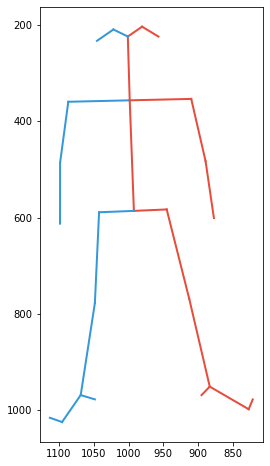

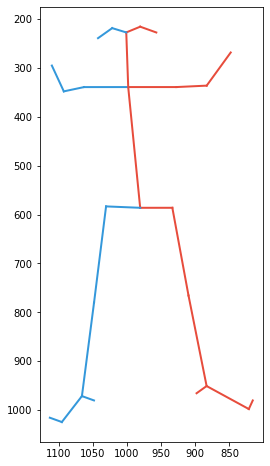

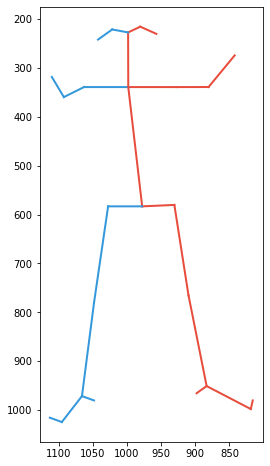

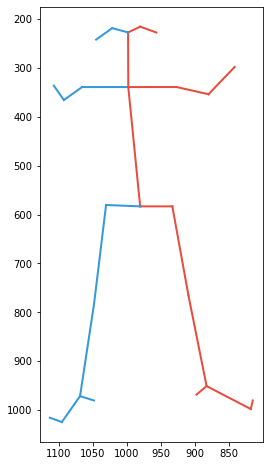

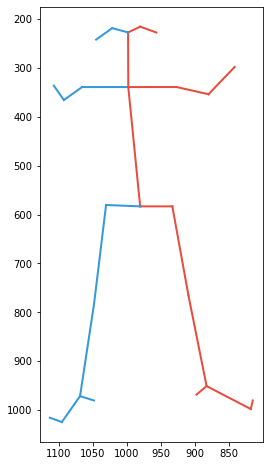

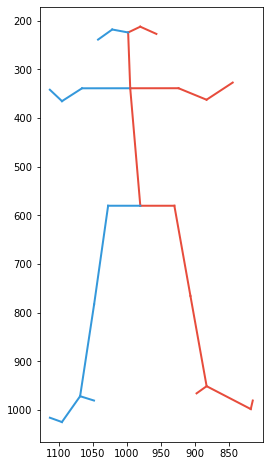

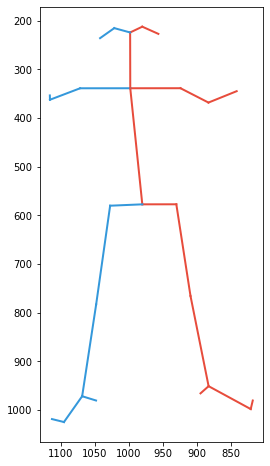

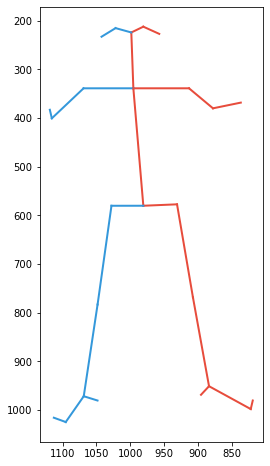

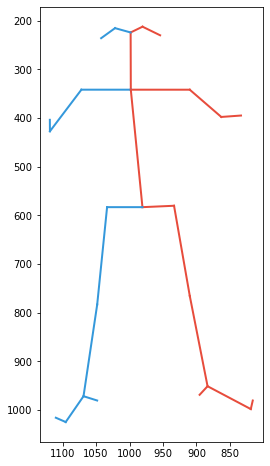

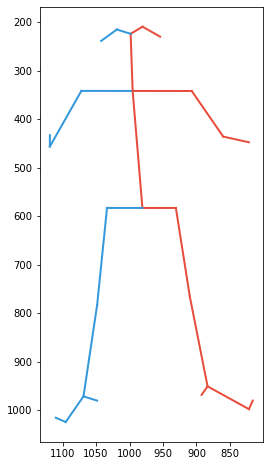

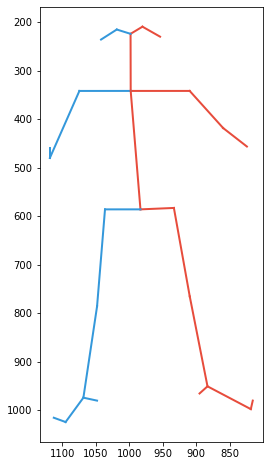

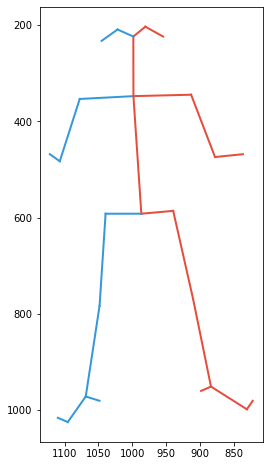

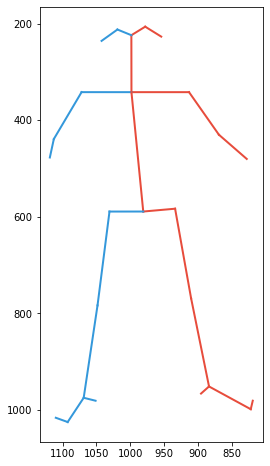

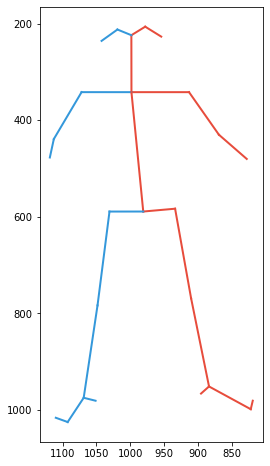

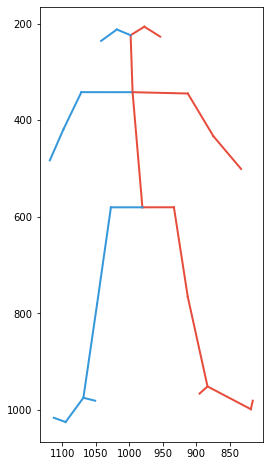

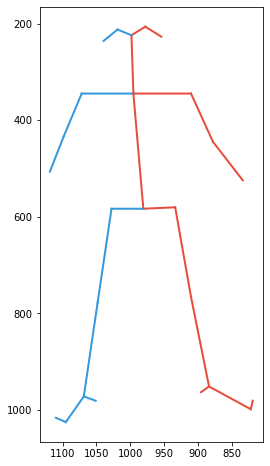

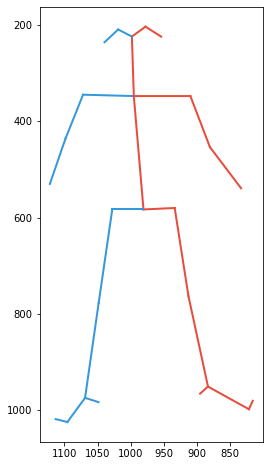

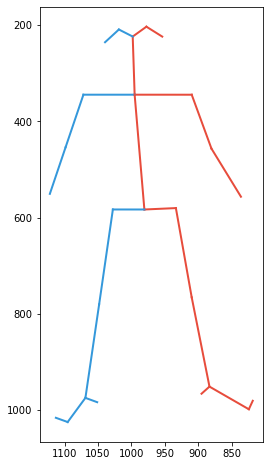

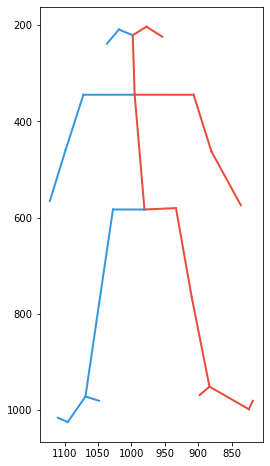

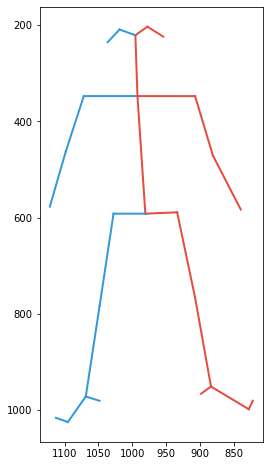

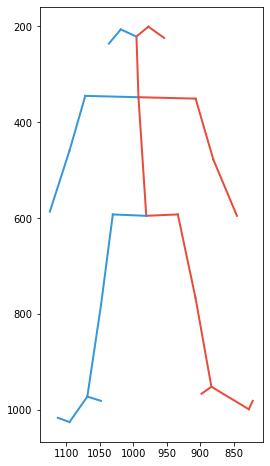

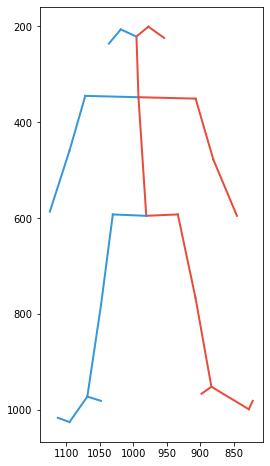

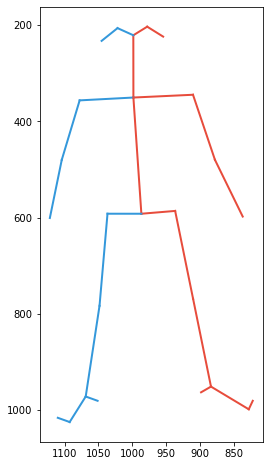

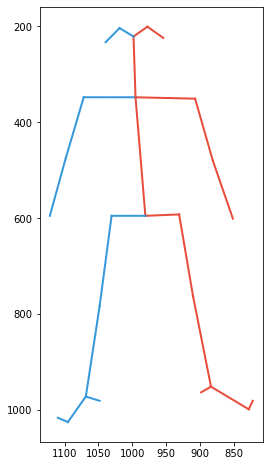

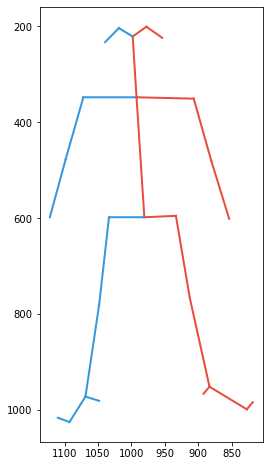

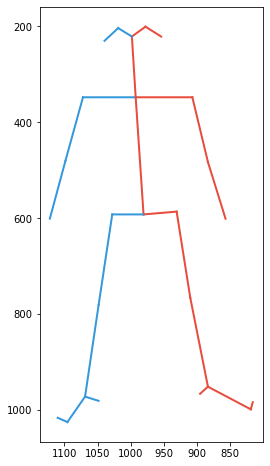

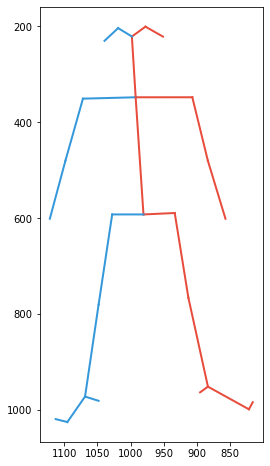

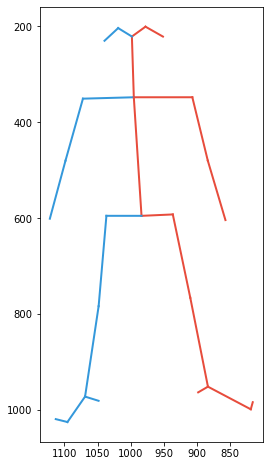

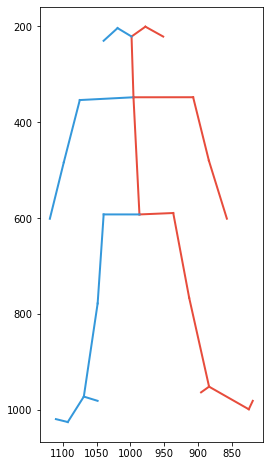

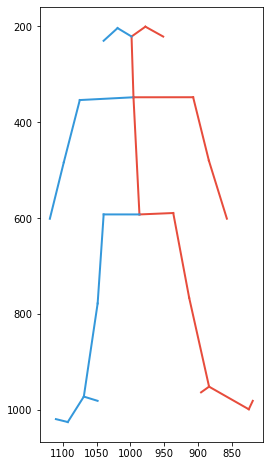

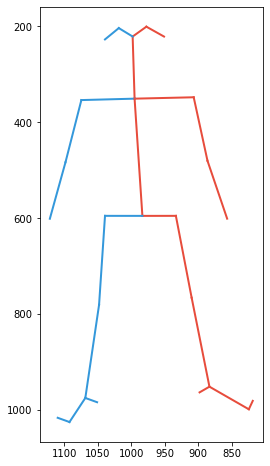

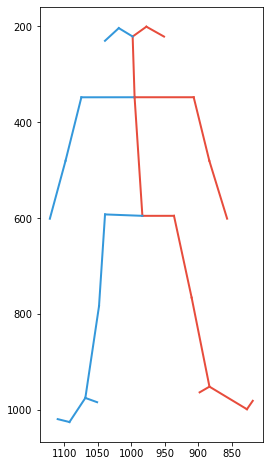

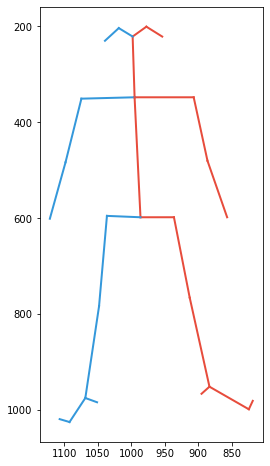

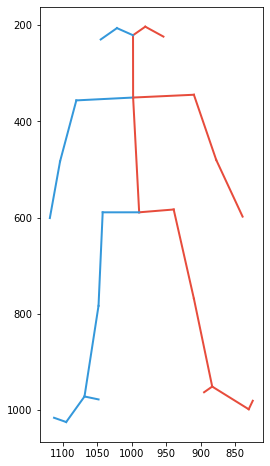

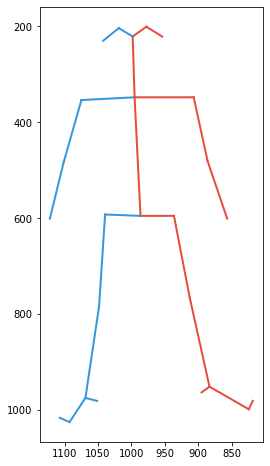

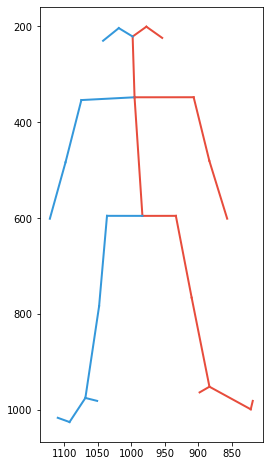

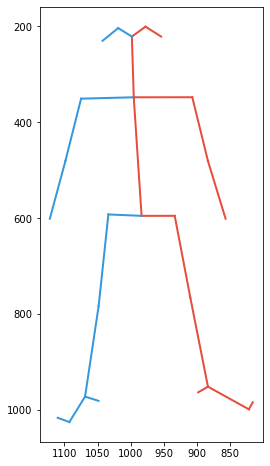

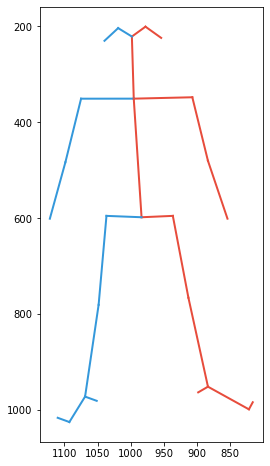

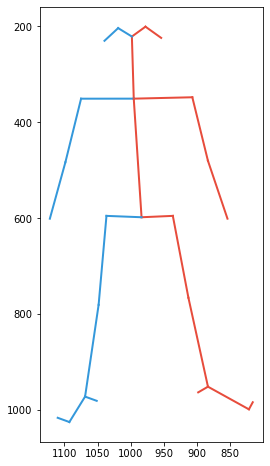

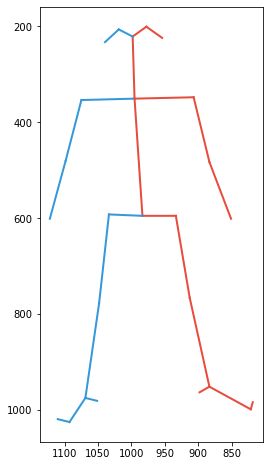

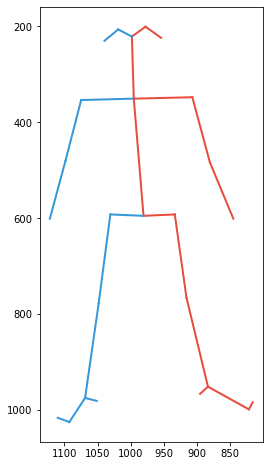

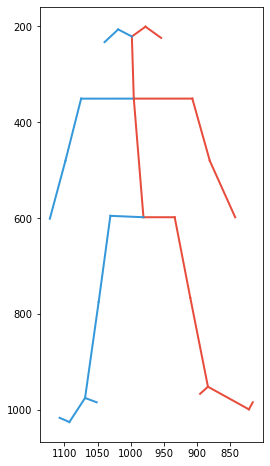

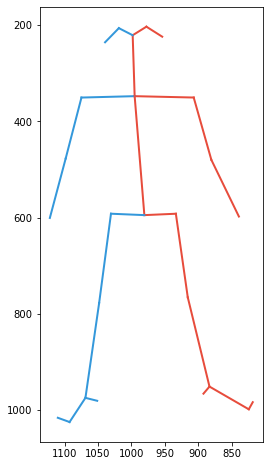

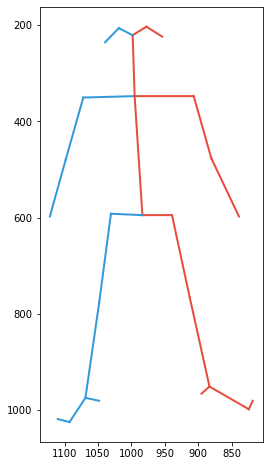

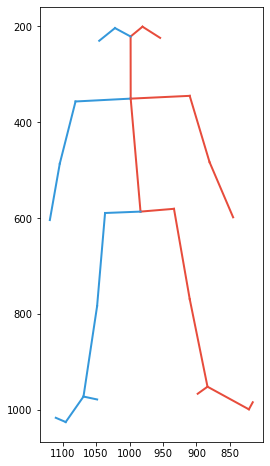

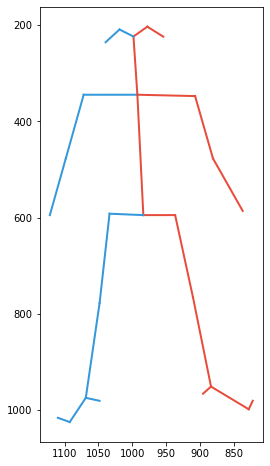

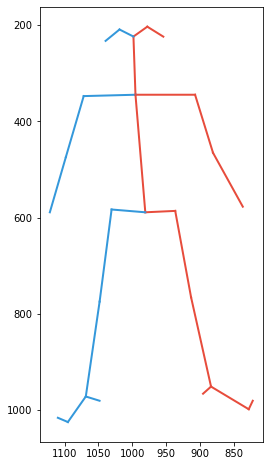

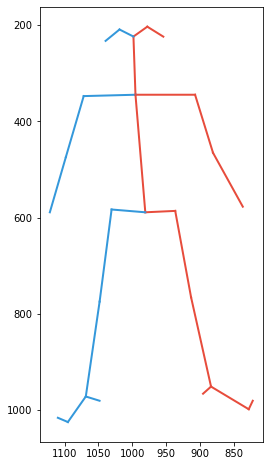

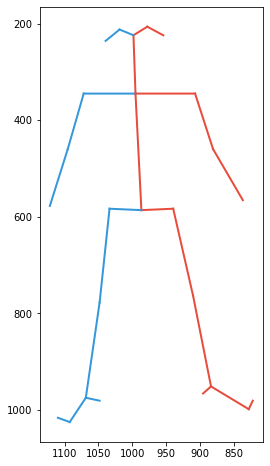

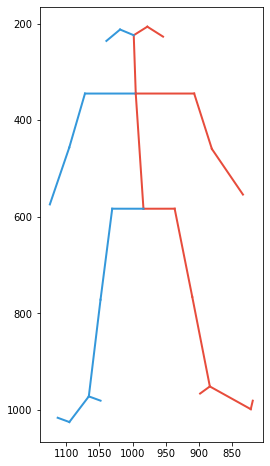

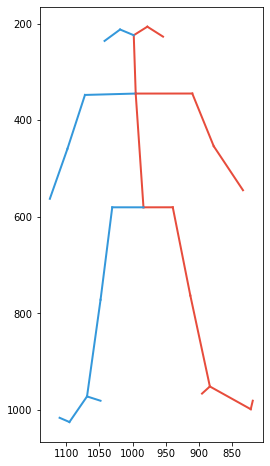

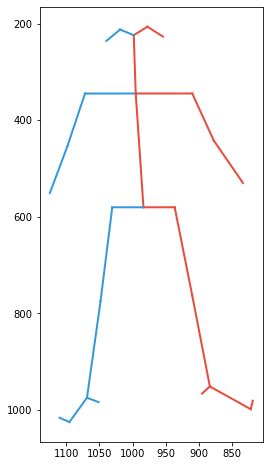

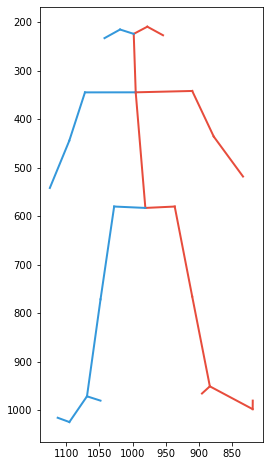

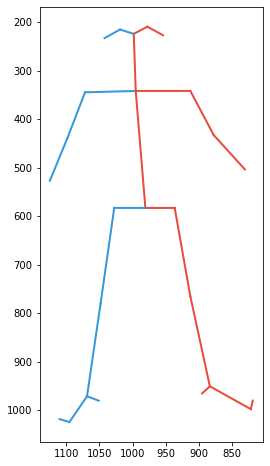

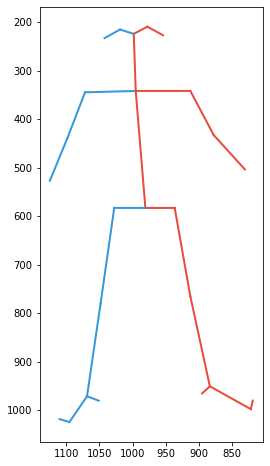

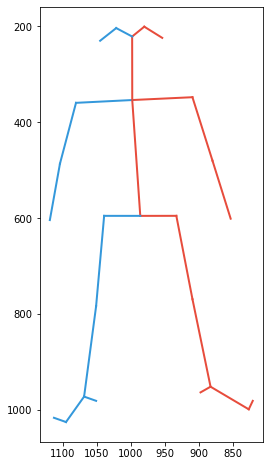

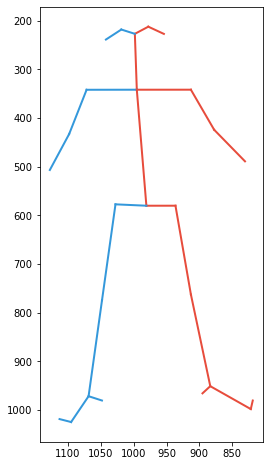

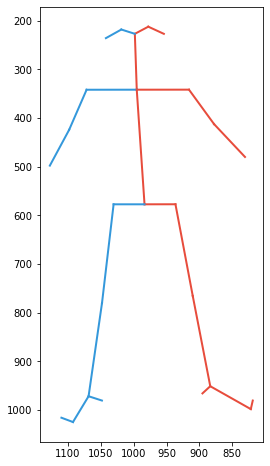

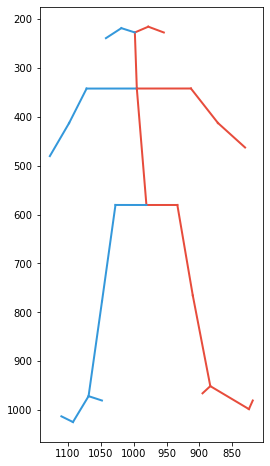

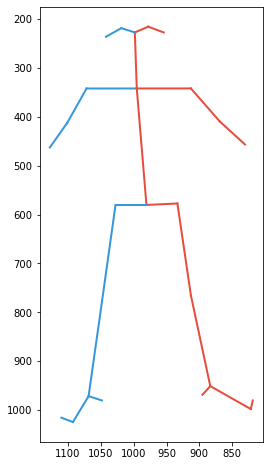

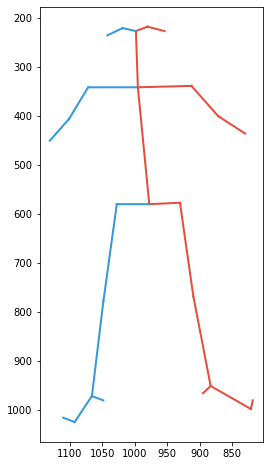

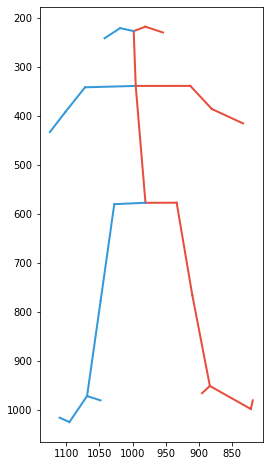

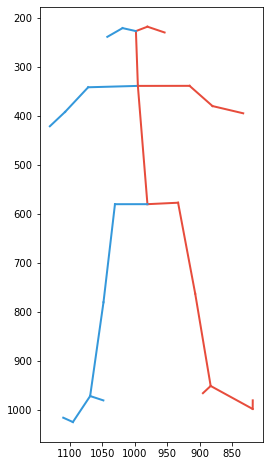

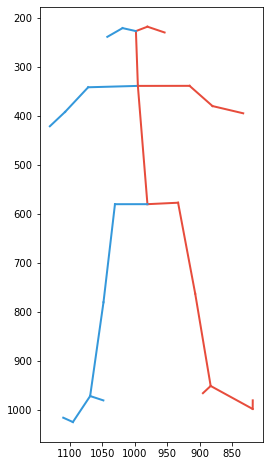

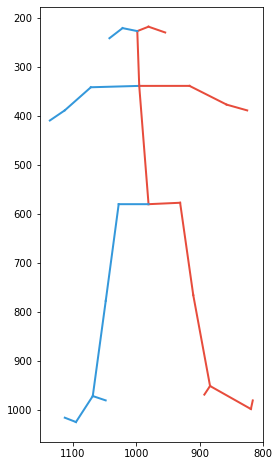

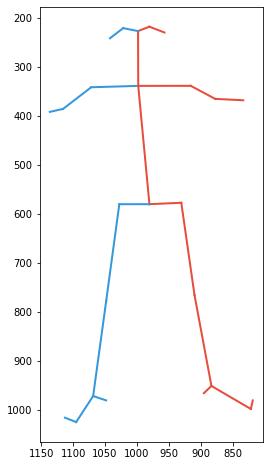

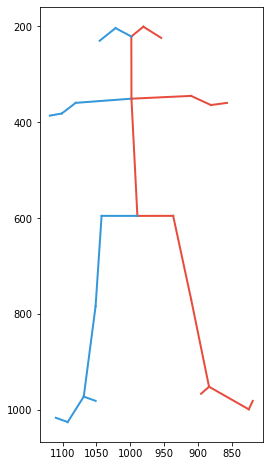

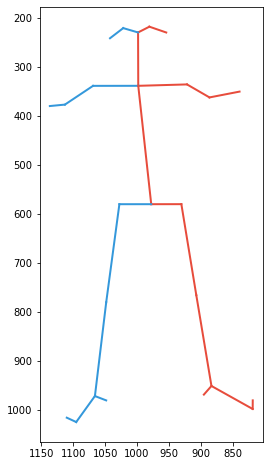

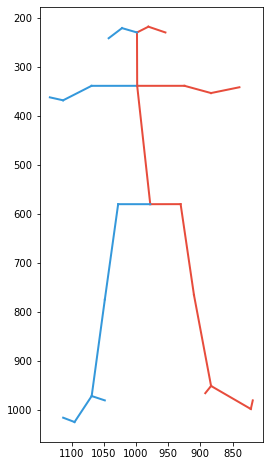

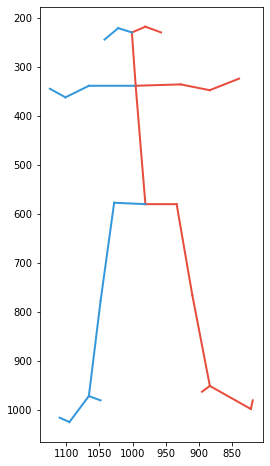

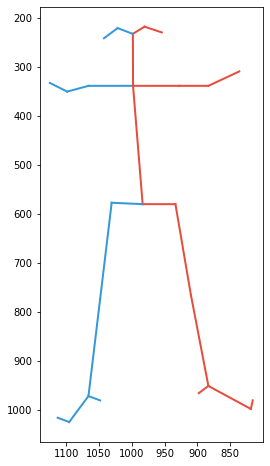

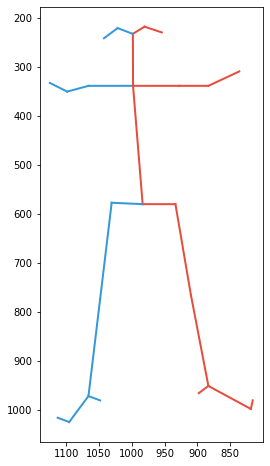

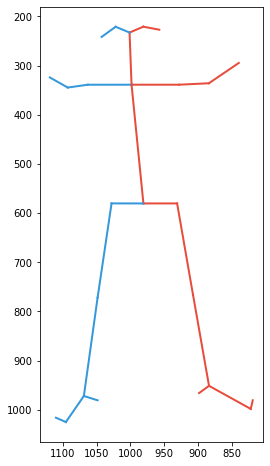

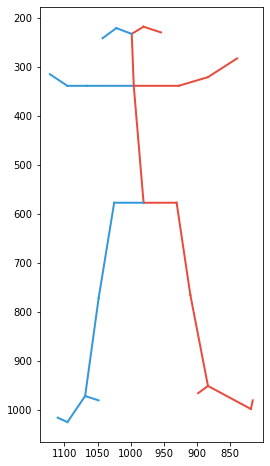

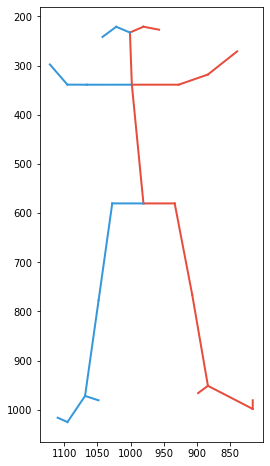

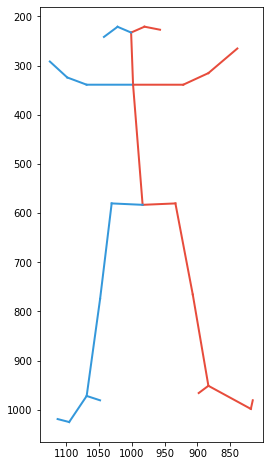

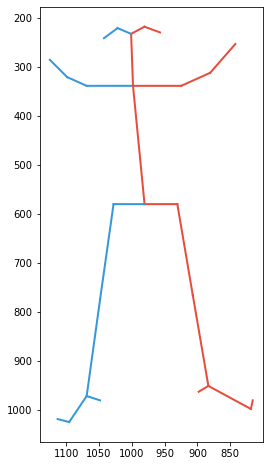

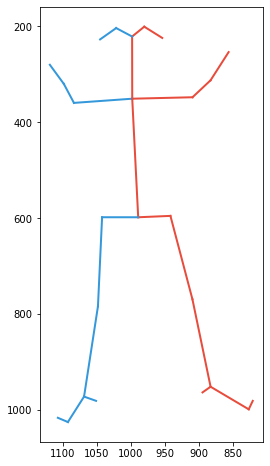

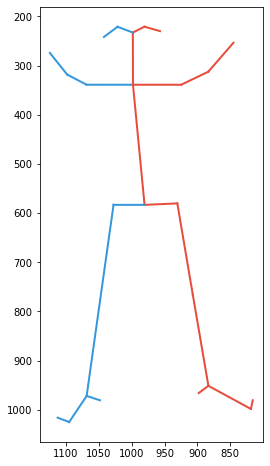

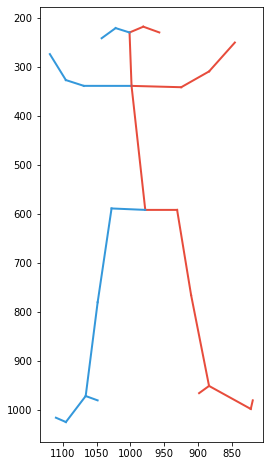

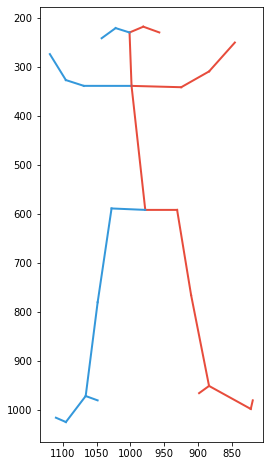

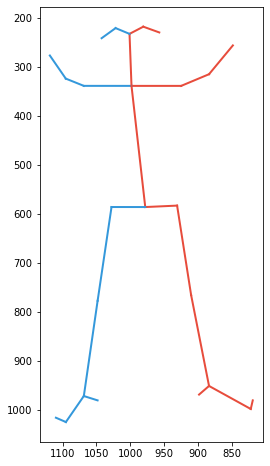

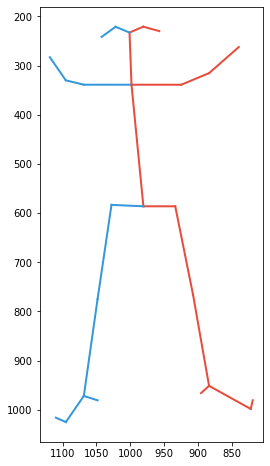

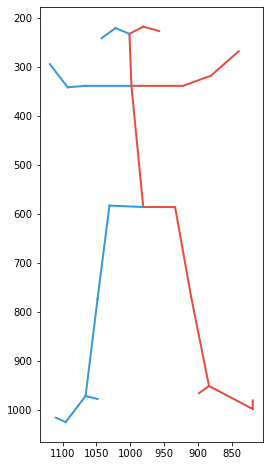

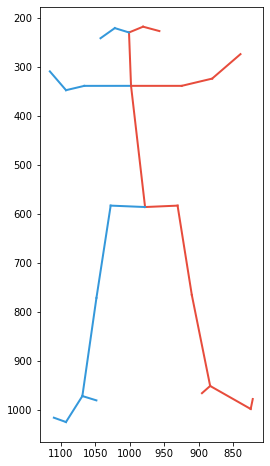

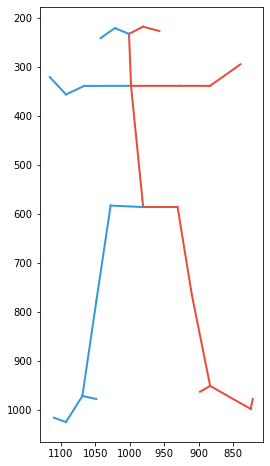

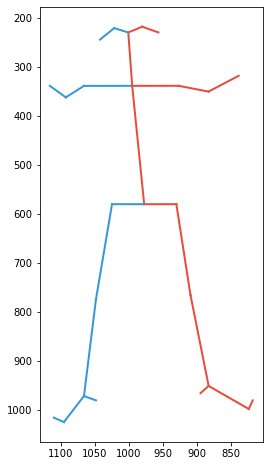

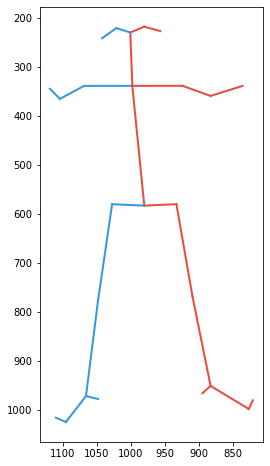

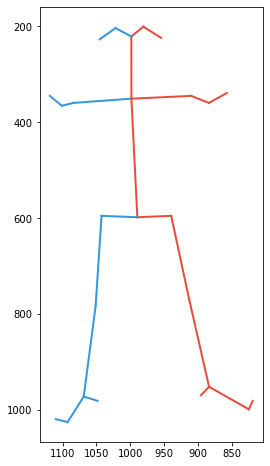

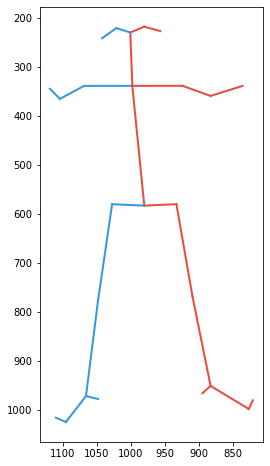

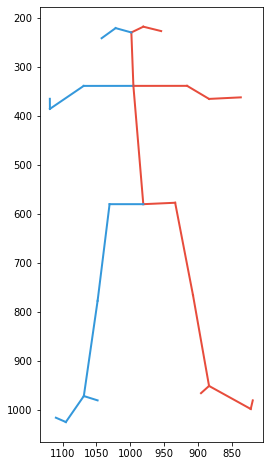

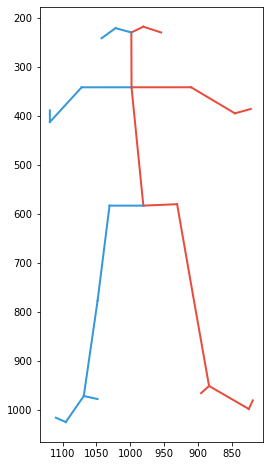

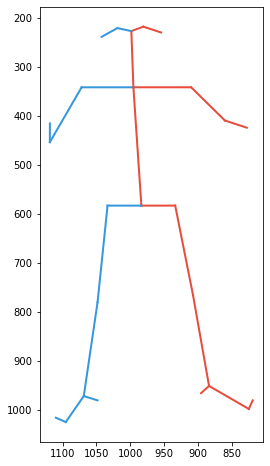

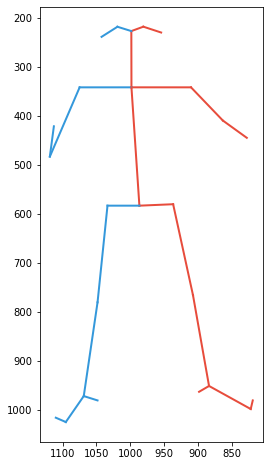

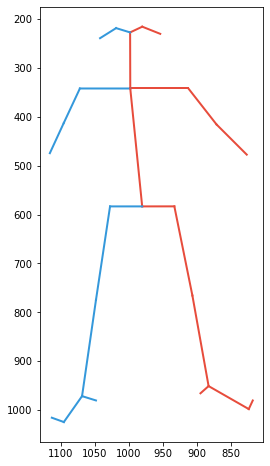

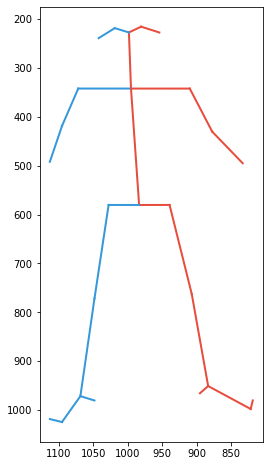

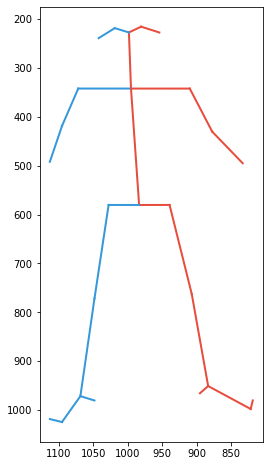

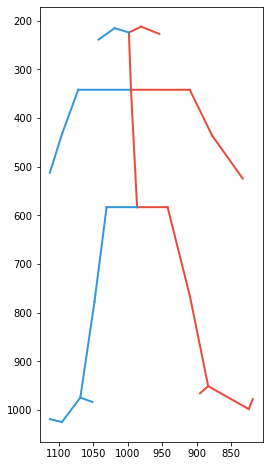

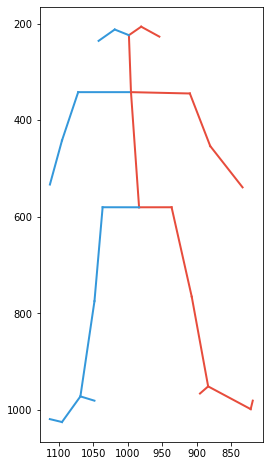

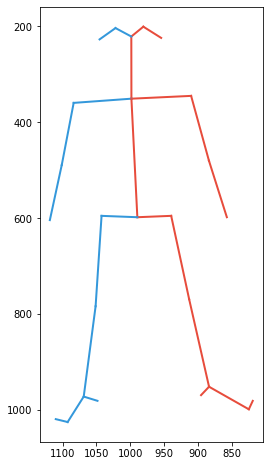

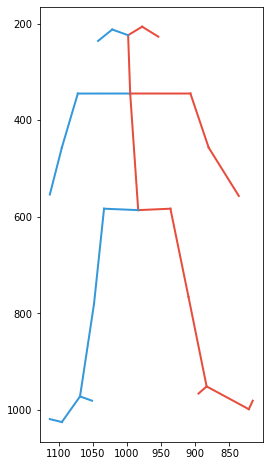

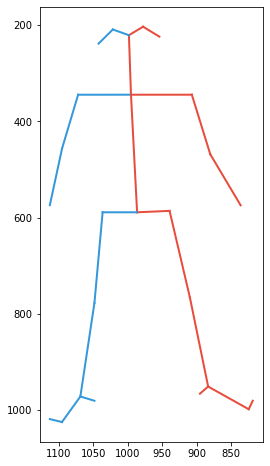

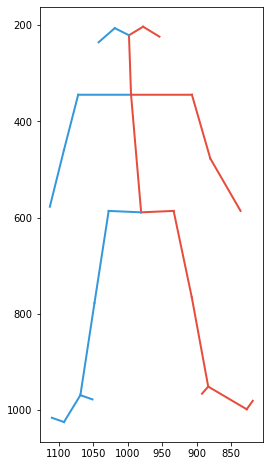

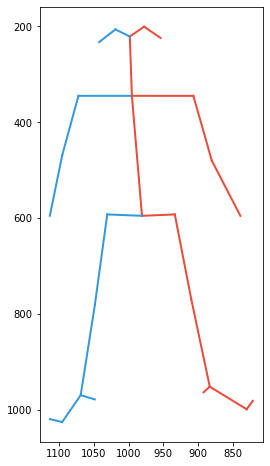

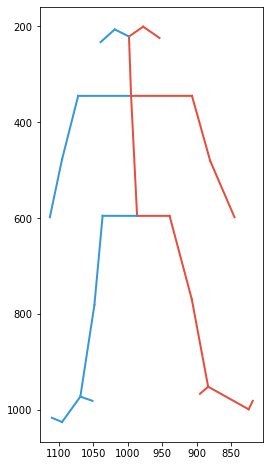

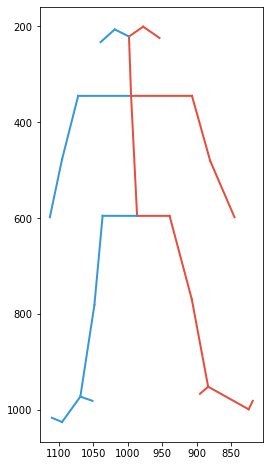

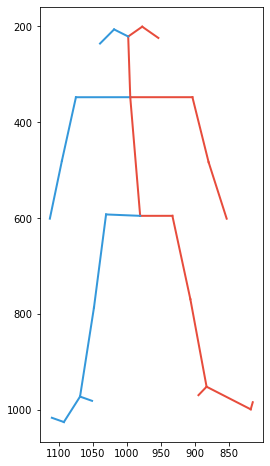

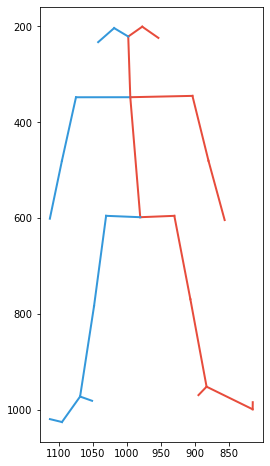

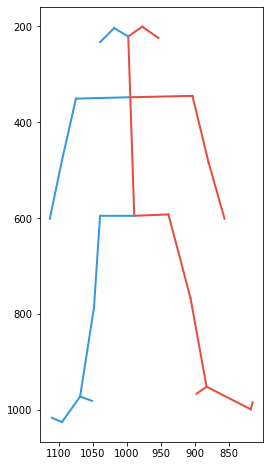

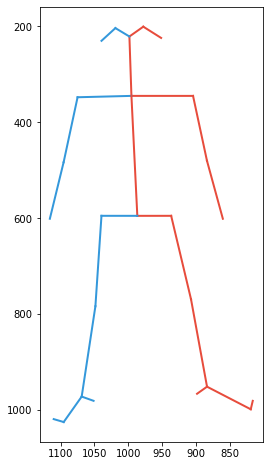

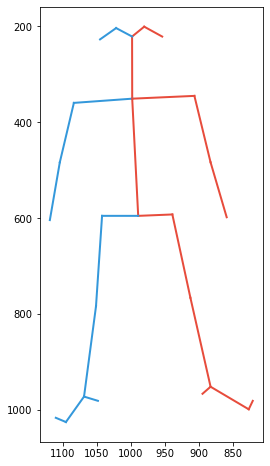

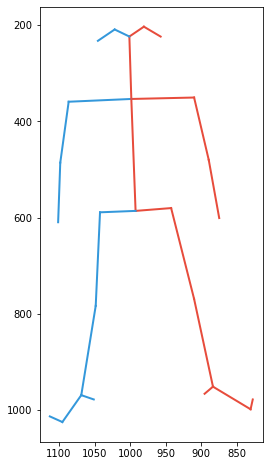

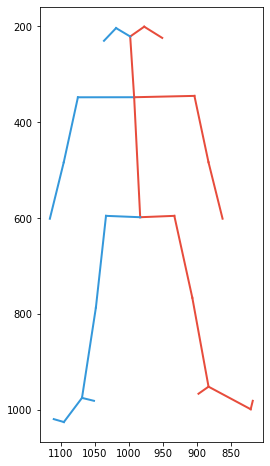

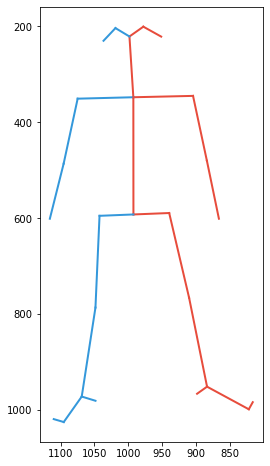

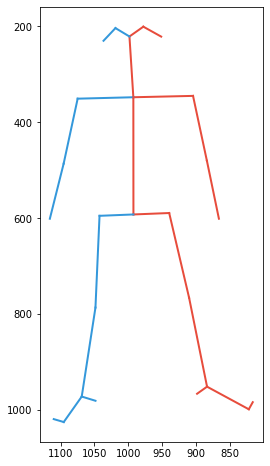

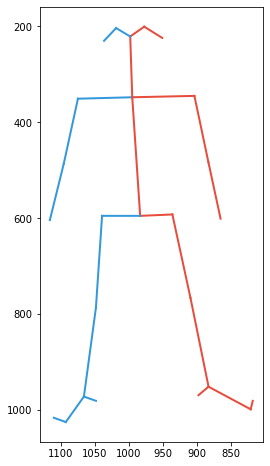

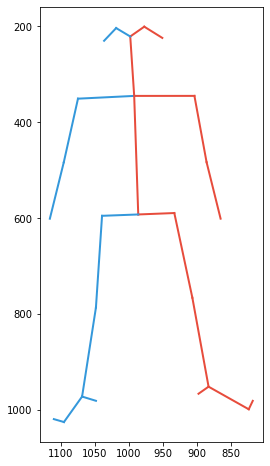

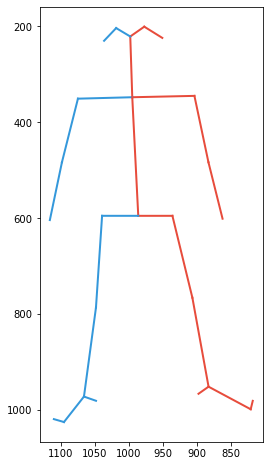

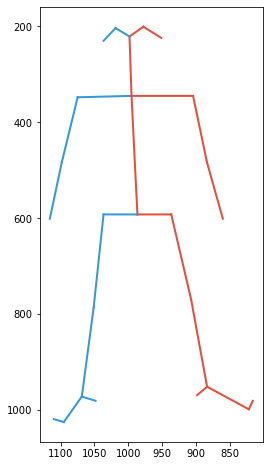

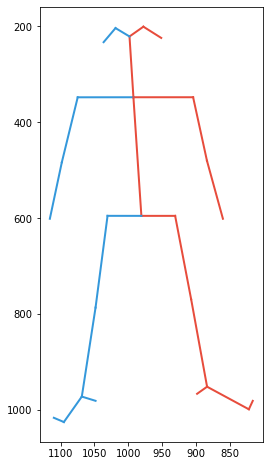

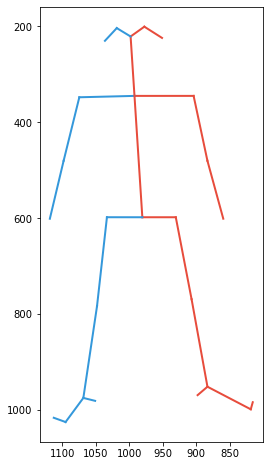

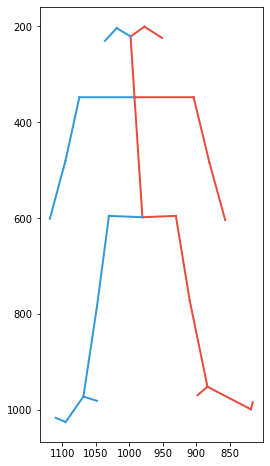

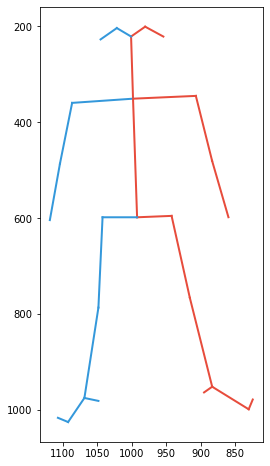

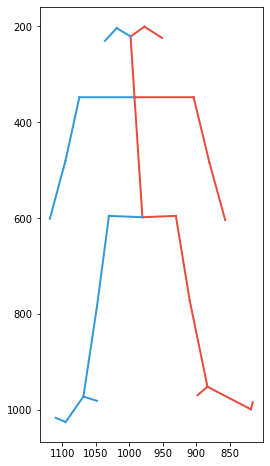

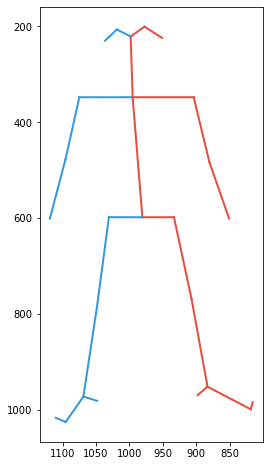

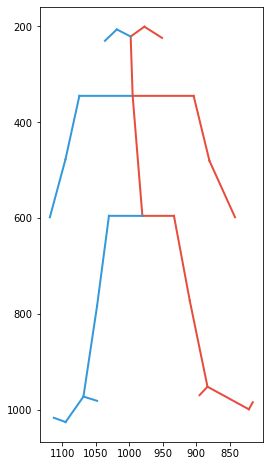

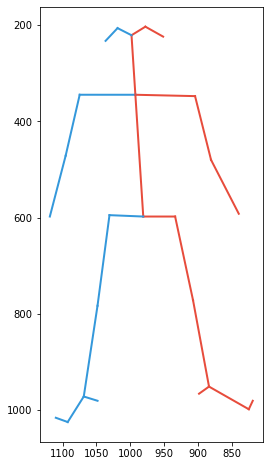

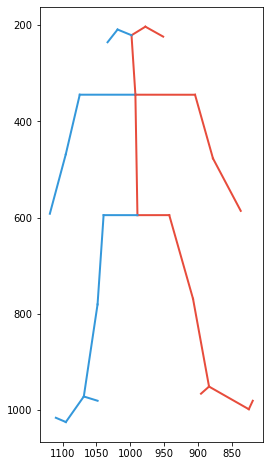

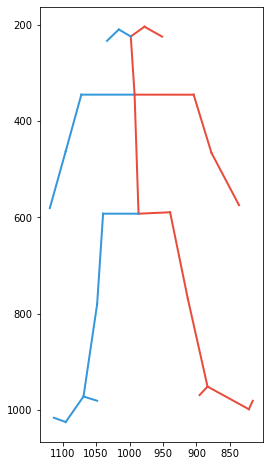

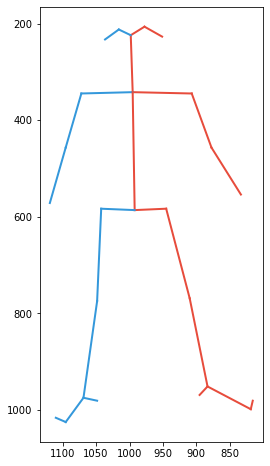

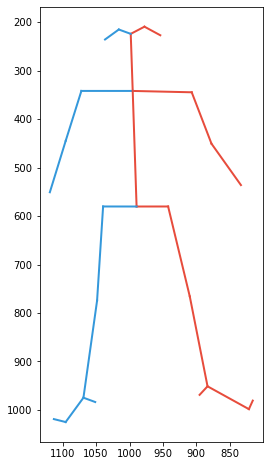

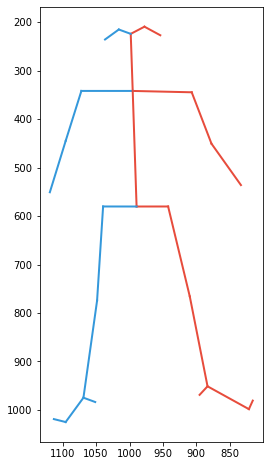

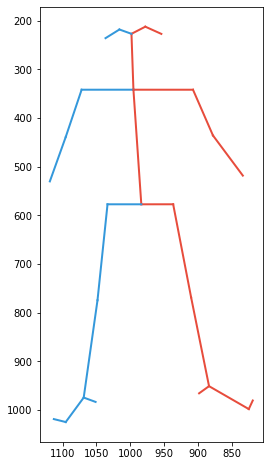

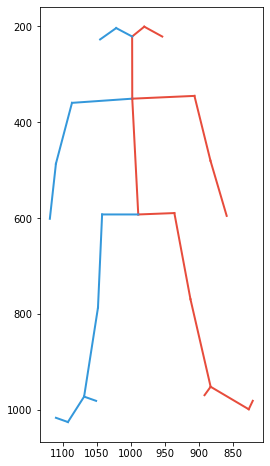

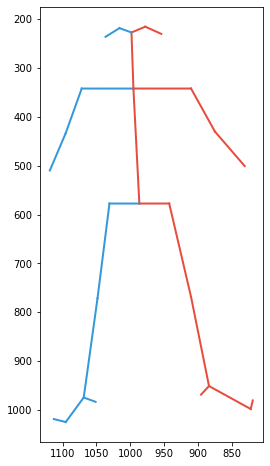

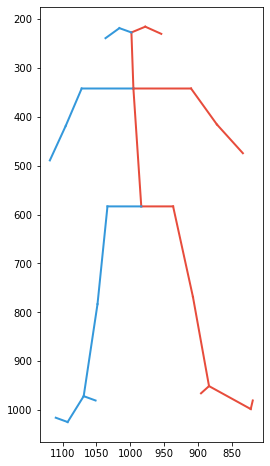

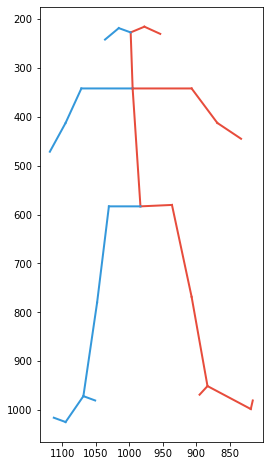

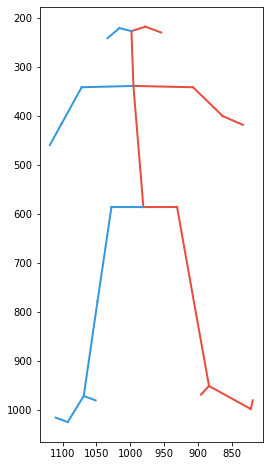

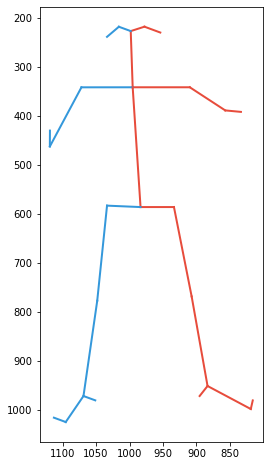

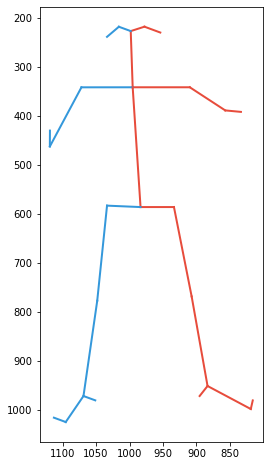

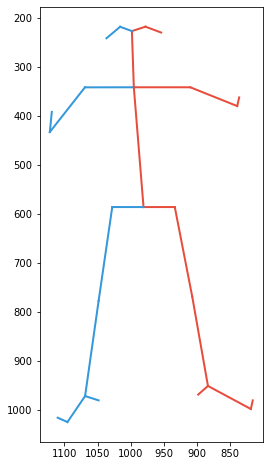

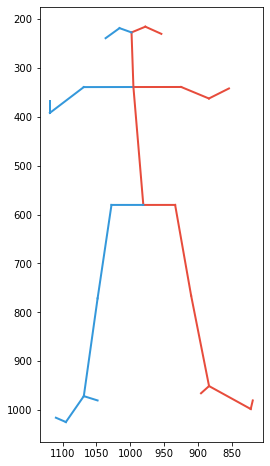

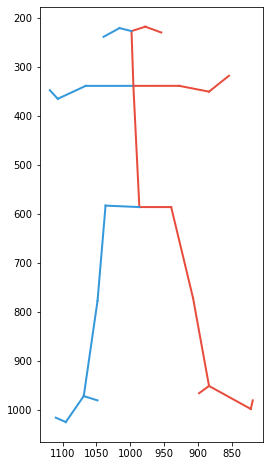

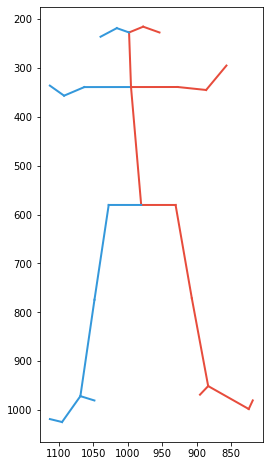

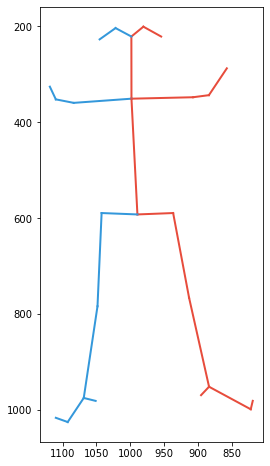

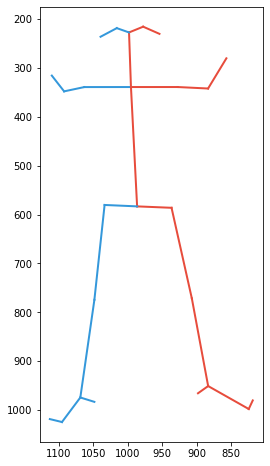

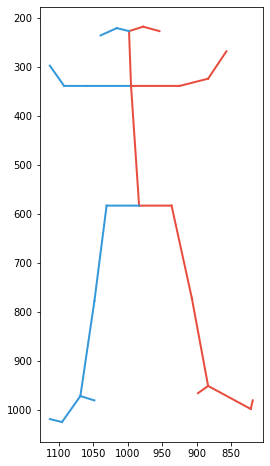

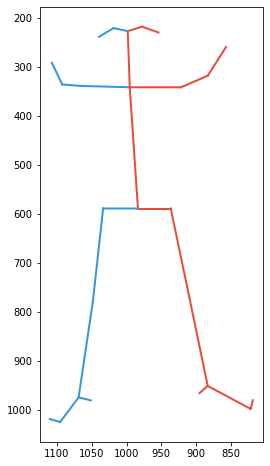

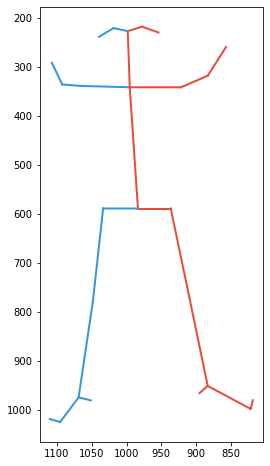

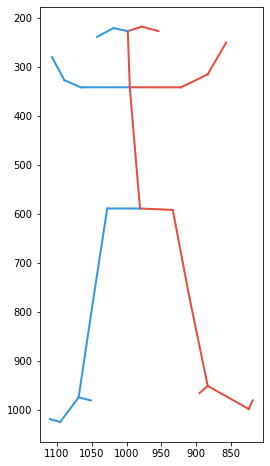

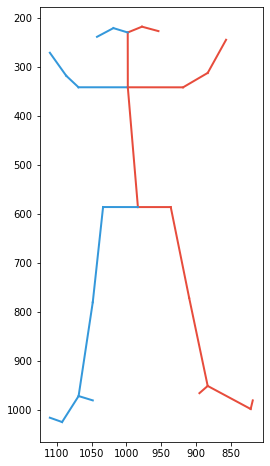

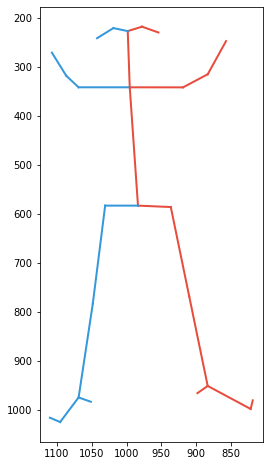

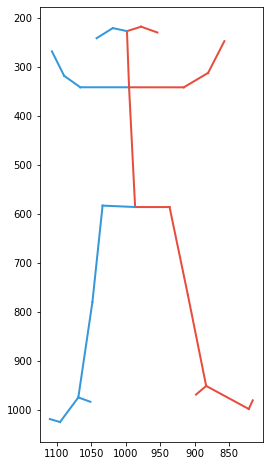

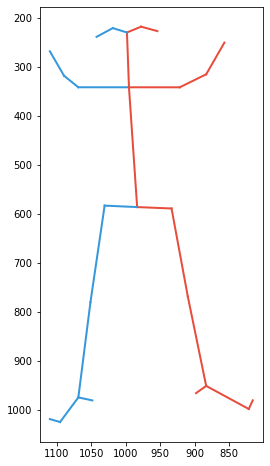

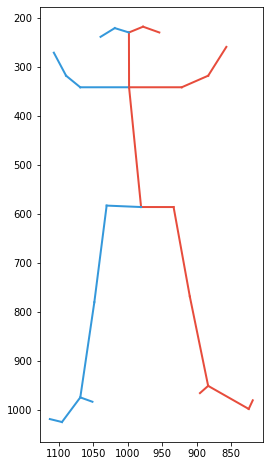

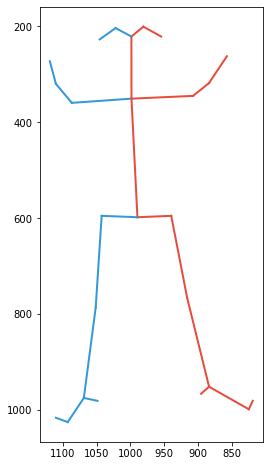

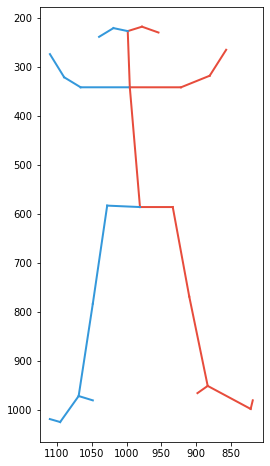

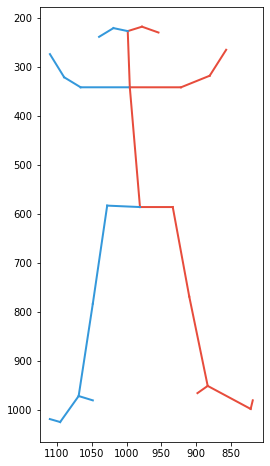

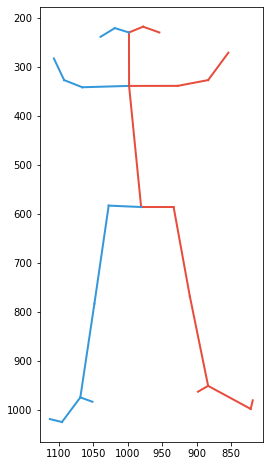

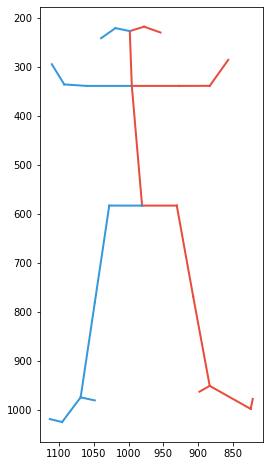

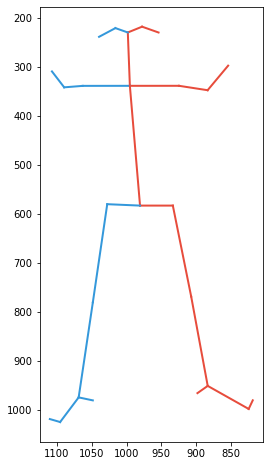

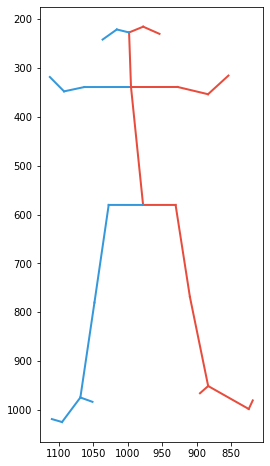

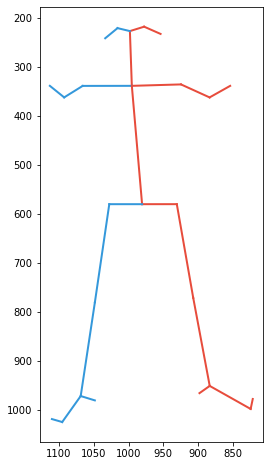

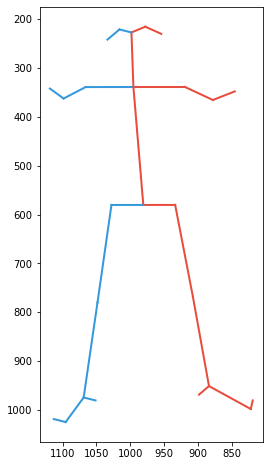

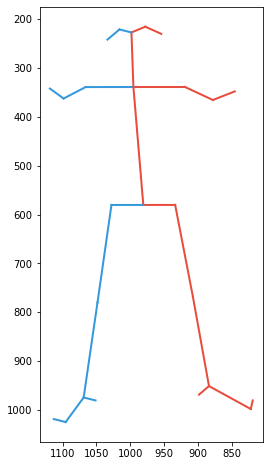

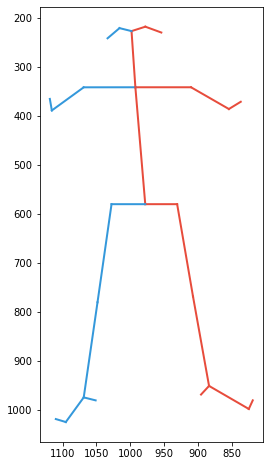

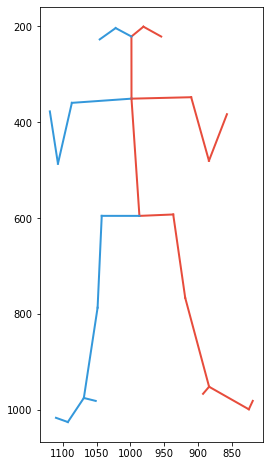

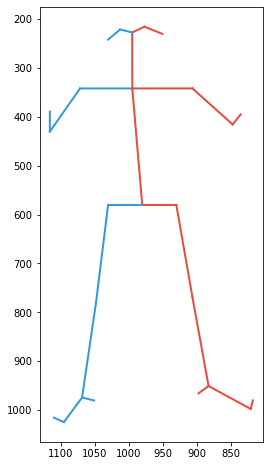

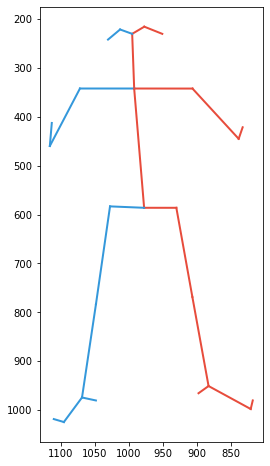

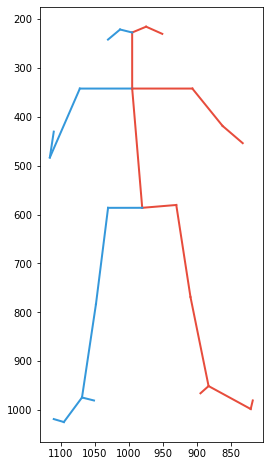

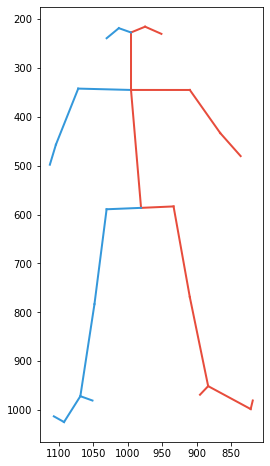

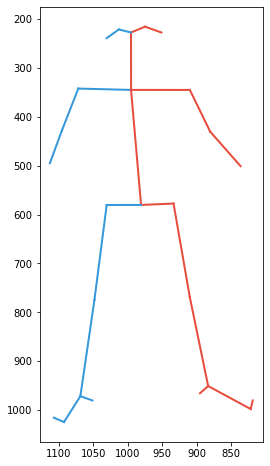

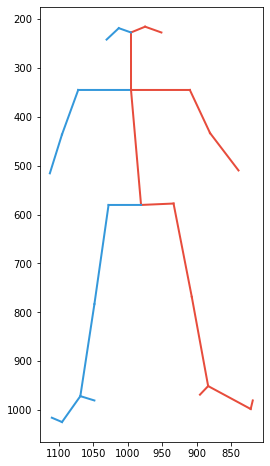

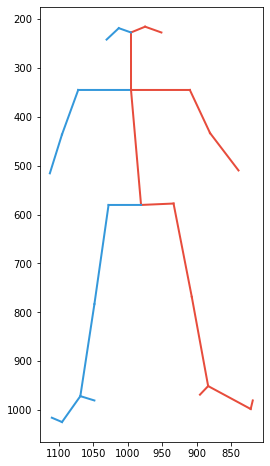

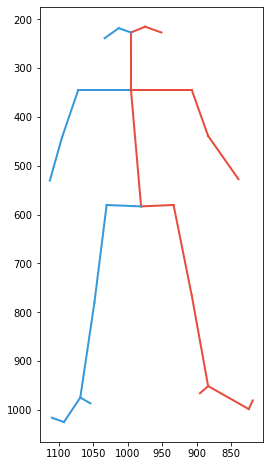

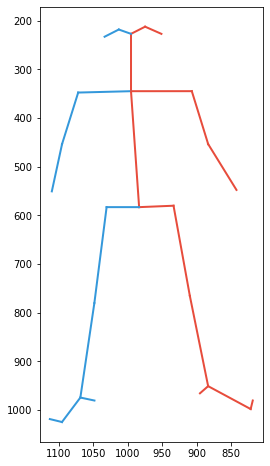

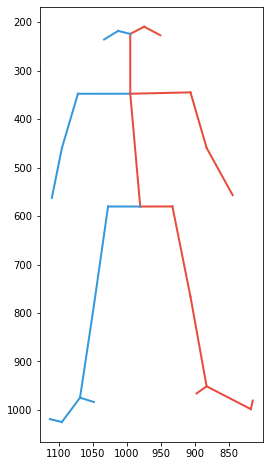

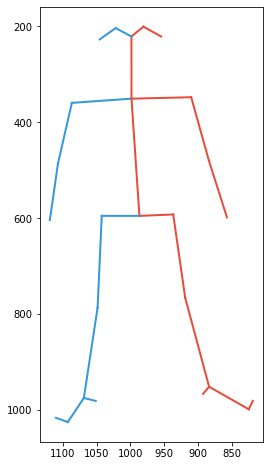

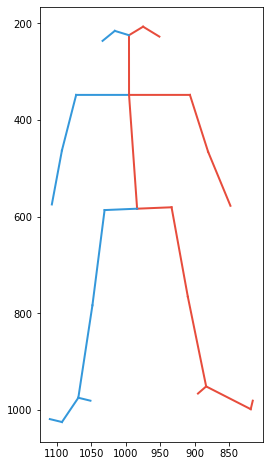

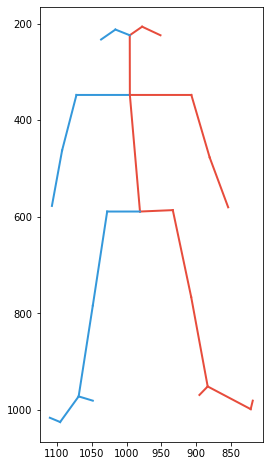

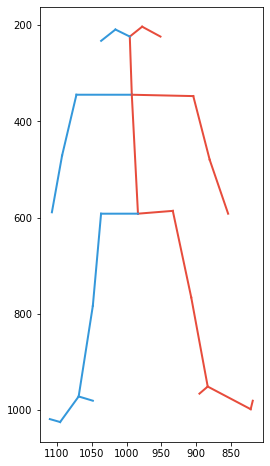

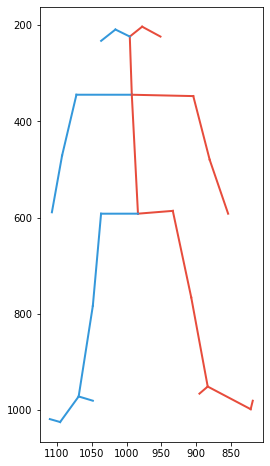

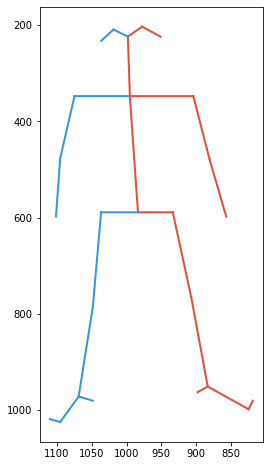

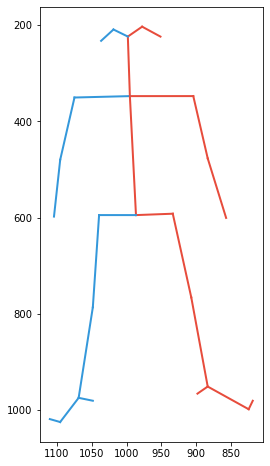

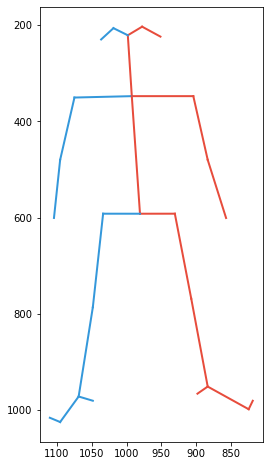

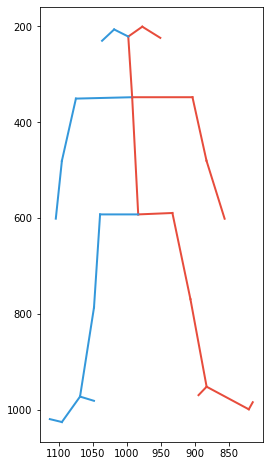

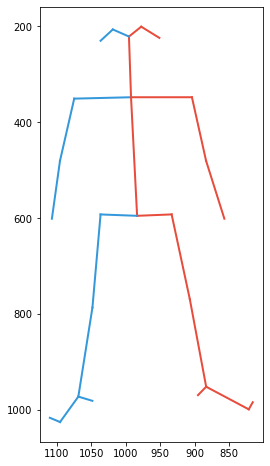

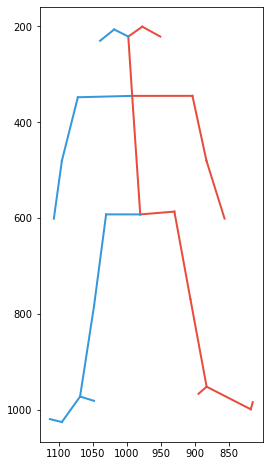

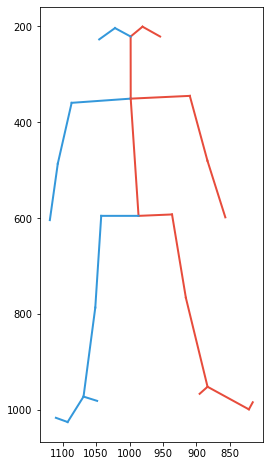

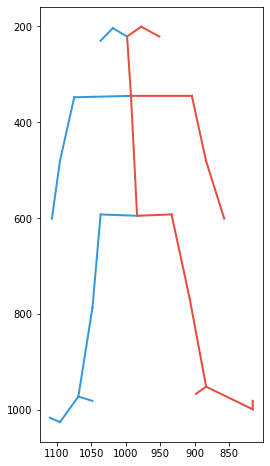

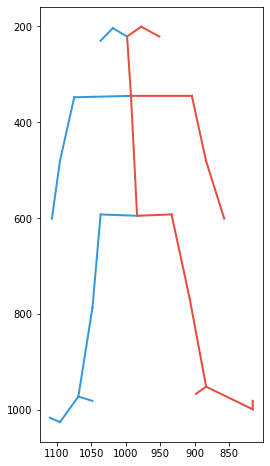

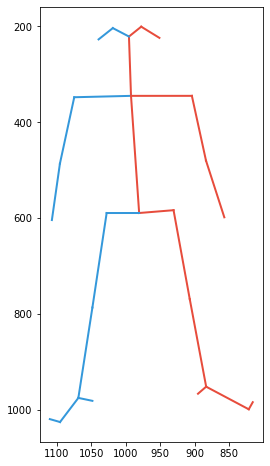

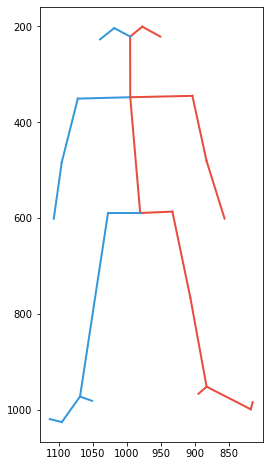

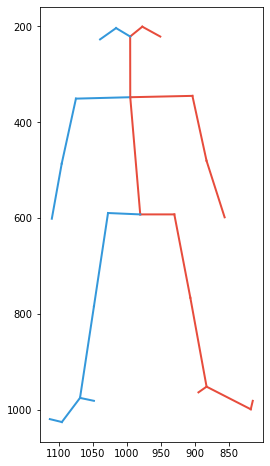

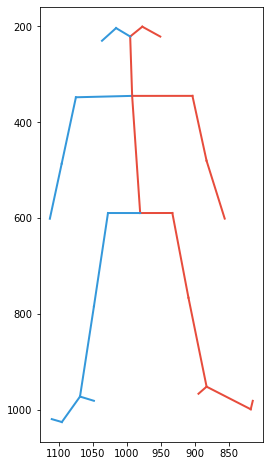

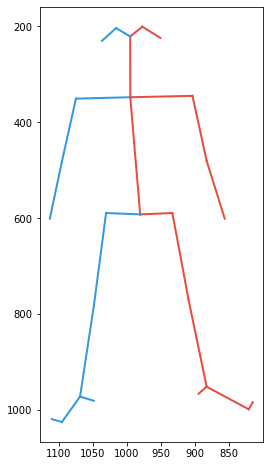

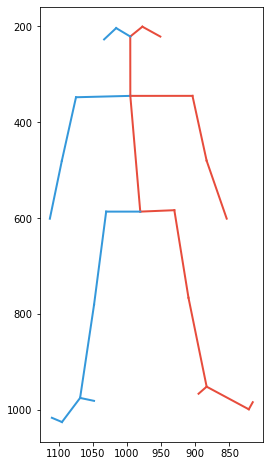

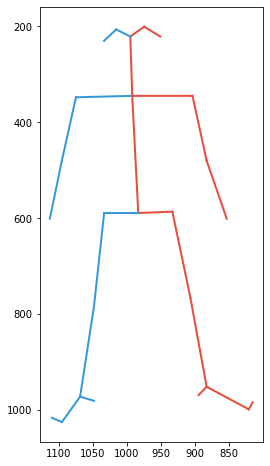

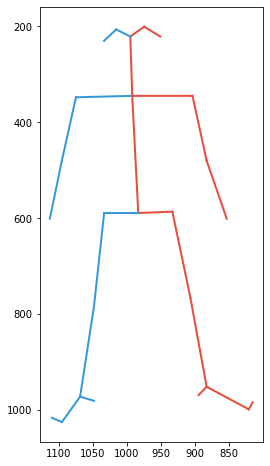

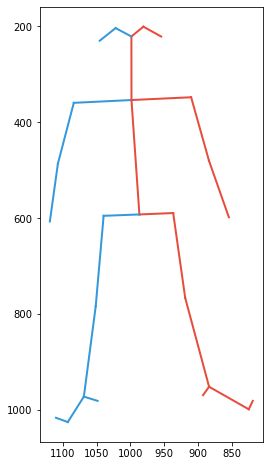

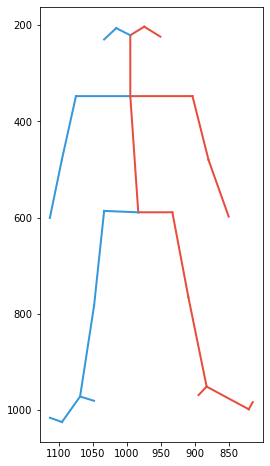

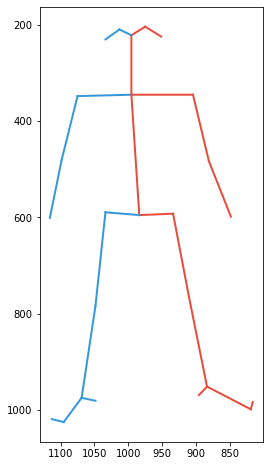

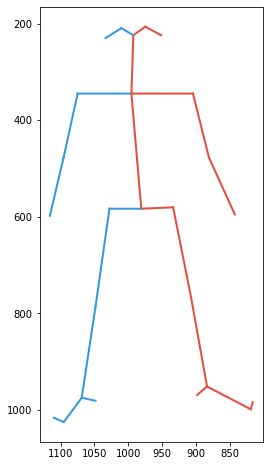

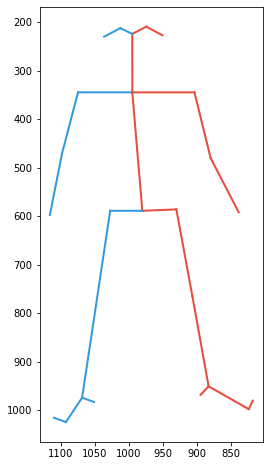

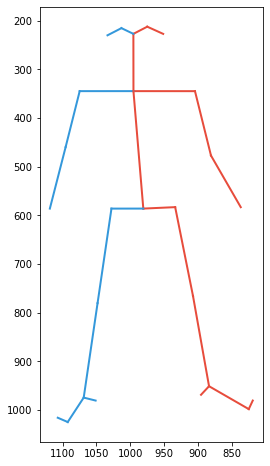

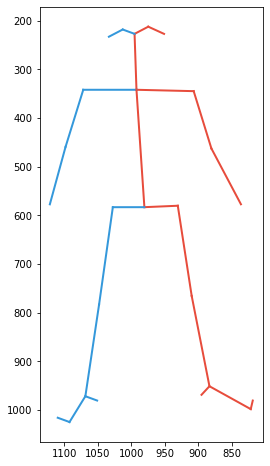

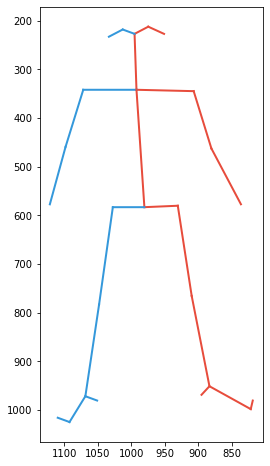

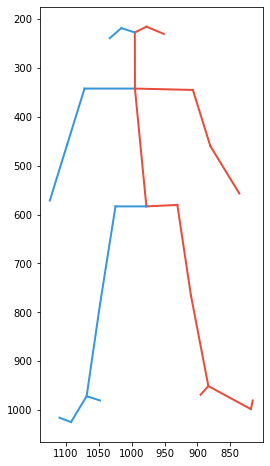

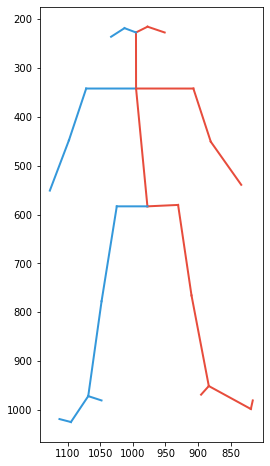

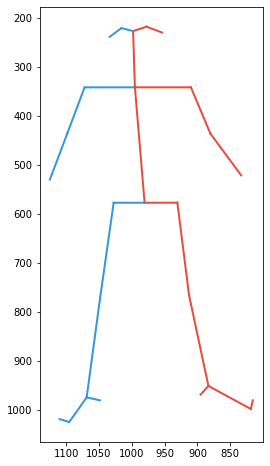

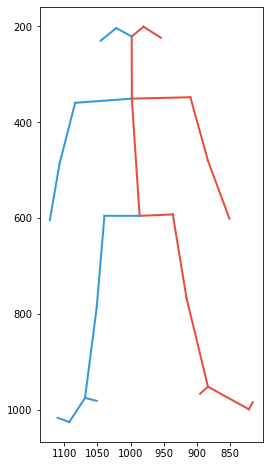

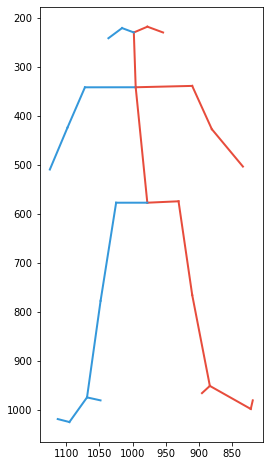

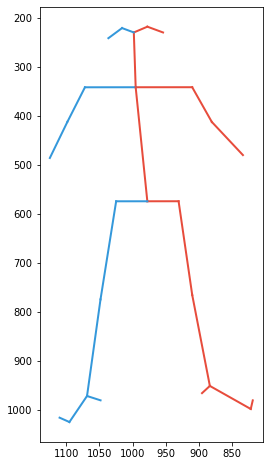

In [26]:
i = 0
for td in ps:
    fig = plt.figure(figsize=(4,8))
    ax = fig.add_subplot()
    ax.invert_xaxis()
    ax.invert_yaxis()
    draw2Dpose(td, ax)
    plt.show()
    fig.savefig('origin_imgs/no_{}.png'.format(i))
    i += 1